# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 400)
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


from sklearn.cluster import KMeans, MiniBatchKMeans

# magic word for producing visualizations in notebook
%matplotlib inline


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [109]:
# load in the data
#azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [ ]:
# Dump the azdias dataframe to a pickle object 
#pickle.dump(azdias, open("azdias.pickle", "wb"))

In [ ]:
# Reload azdias object 
azdias = pickle.load(open("azdias.pickle", "rb"))

In [5]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [45]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [46]:
#from helpers import save_csv
#helpers.save_csv(azdias, 'data_project', 'Udacity_AZDIAS_052018.csv')
#helpers.save_csv(customers, 'data_project', 'Udacity_CUSTOMERS_052018.csv')


## Part 0.1 Data exploration 

In [5]:
#azdias = pd.read_csv('./data_project/Udacity_AZDIAS_052018.csv')
#azdias.drop(['Unnamed: 0'], axis = 1, inplace = True)
#azdias.head()

In [6]:
#customers = pd.read_csv('./data_project/Udacity_CUSTOMERS_052018.csv')
#customers.head()

In [21]:
print('Describe Customers :\n')
display(customers.describe())

print('Describe Population :\n')
display(azdias.describe())

Describe Customers :



,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGE

Describe Population :



,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGE

In [22]:
# The shape of dataframes
print('Shape of azdias dataframe: {}\n'.format(azdias.shape))
print('Shape of customers dataframe: {}\n'.format(customers.shape))

Shape of azdias dataframe: (891221, 366)

Shape of customers dataframe: (191652, 369)



#### check if azdias contains all columns in customers

In [23]:
# check if azdias contains all columns in customers

customers_columns_list = list(customers.columns)
azdias_columns_list = list(azdias.columns)

result =  all(elem in customers_columns_list  for elem in azdias_columns_list)
 
if result:
    print("Yes, customers dataframe contains all columns in azdias dataframe")    
else :
    print("No, customers dataframe does not contain all columns in azdias dataframe")

Yes, customers dataframe contains all columns in azdias dataframe


#### Data_info and Mising values

Now we will explore a little deeper the data. Let's load the data_info.csv file so that we will have more information about the columns. This would help us in our data cleaning processing.

In [110]:
data_info = pd.read_csv('data_info.csv')
data_info.drop(['Attribute','ISBLANK'], axis = 1, inplace = True)
data_info.rename(columns={"Attribute.1": "Attribute", "Missing_value": "Missing_Value"}, inplace = True)

data_info.head(10)

,Attribute,Description,Value,Missing_Value,Meaning
0,AGER_TYP,best-ager typology,-1,[-1],unknown
1,AGER_TYP,best-ager typology,0,[-1],no classification possible
2,AGER_TYP,best-ager typology,1,[-1],passive elderly
3,AGER_TYP,best-ager typology,2,[-1],cultural elderly
4,AGER_TYP,best-ager typology,3,[-1],experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0","[-1,0]",unknown
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,"[-1,0]",< 30 years
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,"[-1,0]",30 - 45 years
8,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,"[-1,0]",46 - 60 years
9,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,"[-1,0]",> 60 years


In [111]:
from helpers import missing_code_df
missing_code_df = missing_code_df(data_info)

Drop Description, Value and Meaning columns

Drop duplicates

Fillna with -1 in columns with no missing code

            == DataFrame ==


,Attribute,Missing_Value
0,AGER_TYP,[-1]
1,ALTERSKATEGORIE_GROB,"[-1,0]"
2,ALTER_HH,[0]
3,ANREDE_KZ,"[-1,0]"
4,ANZ_HAUSHALTE_AKTIV,[-1]


In [112]:
len(data_info.Attribute.unique())

314

In [6]:
# Unique code for missing values
data_info.Missing_Value.unique()

array(['[-1]', '[-1,0]', '[0]', '[10]', '[9]', '[-1,9]'], dtype=object)

## Part 1: Data Cleaning and Data Engineering

### Part 1.1  Check for Missing Values  - azdias df 

We can notice that we have 273 columns with missing data. We can also see below that even before the missing data mapping process, we have few columns with high percentage of missing values, such as ALTER_KIND4 (99.86%), ALTER_KIND3 (99.31%), ALTER_KIND2 (96.69%),ALTER_KIND1 (90.90%), EXTSEL992(73.40%), KK_KUNDENTYP (65.60%).



In [28]:
# columns with missing values
missing_data = azdias.isnull().sum()[azdias.isnull().sum() !=0]

# dictionary with missing values and their respective percentage 

total_rows = azdias.shape[0]
missing_dict = {'Missing_Count': missing_data.values, 
                'Percentage': np.round(missing_data.values*100/(total_rows),2)}


#Create DataFrame
azdias_missing_initial = pd.DataFrame(missing_dict, index = missing_data.index)
azdias_missing_initial.sort_values(by = 'Missing_Count', ascending = False, inplace = True)
print('Number of columns with missing values: ', azdias_missing_initial.shape[0])
display('     azdias_missing_initial DataFrame: ')
azdias_missing_initial


Number of columns with missing values:  273


'     azdias_missing_initial DataFrame: '

,Missing_Count,Percentage
ALTER_KIND4,890016,99.86
ALTER_KIND3,885051,99.31
ALTER_KIND2,861722,96.69
ALTER_KIND1,810163,90.90
EXTSEL992,654153,73.40
KK_KUNDENTYP,584612,65.60
ALTERSKATEGORIE_FEIN,262947,29.50
D19_SOZIALES,257113,28.85
D19_LOTTO,257113,28.85
D19_BANKEN_ONLINE_QUOTE_12,257113,28.85


In [29]:
# Double-check
print('Percentage of missing values (ALTER_KIND4): ', round(100*azdias.isnull().sum()['ALTER_KIND4']/ total_rows,2))
print('Percentage of missing values (ALTERSKATEGORIE_FEIN): ',round(100*azdias.isnull().sum()['ALTERSKATEGORIE_FEIN']/ total_rows,2))

Percentage of missing values (ALTER_KIND4):  99.86
Percentage of missing values (ALTERSKATEGORIE_FEIN):  29.5


### Part 1.2 Create dataframe with attributes and the missing codes from data_info.csv file : 

In [14]:
#missing_code_df = data_info.drop(['Description','Value','Meaning'], axis = 1)
#missing_code_df.set_index('Attribute', inplace = True)
#missing_code_df['Missing_value'] = missing_code_df['Missing_value'].str.replace('[','').replace(']','').split(',').values

display('Missing codes and dtype: ',missing_code_df.Missing_Value.unique())
print()
missing_code_df.head()

'Missing codes and dtype: '

array(['[-1]', '[-1,0]', '[0]', '[10]', '[9]', '[-1,9]'], dtype=object)

,Attribute,Missing_Value
0,AGER_TYP,[-1]
1,ALTERSKATEGORIE_GROB,"[-1,0]"
2,ALTER_HH,[0]
3,ANREDE_KZ,"[-1,0]"
4,ANZ_HAUSHALTE_AKTIV,[-1]


In [15]:
len(missing_code_df.Attribute.unique())

314

In [16]:

missing_code_df.drop_duplicates(keep='first',inplace=True) 
display(len(missing_code_df.Attribute.unique()))

missing_code_df.head()

314

,Attribute,Missing_Value
0,AGER_TYP,[-1]
1,ALTERSKATEGORIE_GROB,"[-1,0]"
2,ALTER_HH,[0]
3,ANREDE_KZ,"[-1,0]"
4,ANZ_HAUSHALTE_AKTIV,[-1]


In [16]:
len(missing_code_df.Attribute)

315

In [33]:
missing_code_df.isnull().sum()

Attribute        0
Missing_Value    0
dtype: int64

In [34]:
# Some variables are not categorical, and have no missing value code
# let's give them a -1 code so that we can use the built in function eval() to build our dictionary with int codes
missing_code_df.fillna('[-1]', inplace = True)

In [12]:
# Create a dictionary with attribute as key and its respective missing code as value
from helpers import create_missing_code_dict
missing_dict = create_missing_code_dict(missing_code_df)
#missing_dict   

I noticed that there are attributes in the azdias dataframe that are missing in the data_info dataframe. To be more specific, we have  93 missing Attributes and because of that we don't have information regarding their missing code.So, I will only consider nan as missing value for those attributes( I could try to consider 0 as missing value but I have no information regarding those features) 

In [36]:
missing_column_count =0
present_column_count = 0
missing_column_list = []

for col in azdias.columns[1:]:
    if col not in missing_dict:
        missing_column_list.append(col)
        missing_column_count += 1
        pass
    else:
        present_column_count +=1
print('Number of columns of azdias df that are missing in data_info df: ', missing_column_count)
print('Number of columns of azdias df contained in data_info df: ', present_column_count)

Number of columns of azdias df that are missing in data_info df:  93
Number of columns of azdias df contained in data_info df:  272


In [37]:
# Calculate number missing columns that have 0 (potencial missing value)
# NOTE : I am not considering 0 as missing value. This is just a test
zero_one_missing_code = []
for col in missing_column_list:
   # for val in azdias[col].value_counts().index:
        if 0 in azdias[col].value_counts().index:
           zero_one_missing_code.append(col)
print('Number of columns that contains 0: ',len(zero_one_missing_code))       

Number of columns that contains 0:  53


In [13]:
from helpers import valid_values_dict
valid_values_dict = valid_values_dict(azdias, missing_dict)

 We can see below that the missing codes in the azdias dataframe has been converted to nan values.

In [14]:
# Dataframe with missing codes converted to nan
azdias_after_encoding = azdias.copy()


# skip LNR column
for col in azdias.columns[1:]:  

    azdias_after_encoding[col] = azdias_after_encoding[col].map(valid_values_dict[col])
    #azdias[col] = azdias[col].map(valid_values_dict[col])

azdias_after_encoding.head()
#azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [15]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [16]:
# total of missing values per columns after converting codes
total_nan_after_encoding = azdias_after_encoding.isnull().sum()
# total of missing values per columns before converting codes
total_nan_before_encoding = azdias.isnull().sum()

#difference

diff = total_nan_after_encoding - total_nan_before_encoding

#

In [17]:
print('Missing values before encoding:', total_nan_before_encoding.sum())
print('Missing values after encoding:', total_nan_after_encoding.sum())
print('Total increase after encoding:', diff.sum())

Missing values before encoding: 33492923
Missing values after encoding: 54626545
Total increase after encoding: 21133622


From now on we can work on the new dataframe.

In [18]:
# Dump the azdias_after_encoding dataframe to a pickle object since it takes up so much room in memory.
#pickle.dump(azdias_after_encoding, open("azdias_after_encoding.pickle", "wb"))

### 1.3 Analysing Missing values

In [28]:
#azdias_after_encoding  = pickle.load(open("azdias_after_encoding.pickle", "rb"))

In [19]:
missing_dict = {'Before_Encoding': total_nan_before_encoding[1:],
               'After_Enconding': total_nan_after_encoding[1:],
               'Difference':diff[1:], 
               'Percent_nan': 100* total_nan_after_encoding/ azdias.shape[0]}

missing_df = pd.DataFrame(missing_dict)
missing_df.head(10)

,Before_Encoding,After_Enconding,Difference,Percent_nan
AGER_TYP,0.0,677503.0,677503.0,76.019640
AKT_DAT_KL,73499.0,73499.0,0.0,8.247000
ALTERSKATEGORIE_FEIN,262947.0,262947.0,0.0,29.504130
ALTERSKATEGORIE_GROB,0.0,0.0,0.0,0.000000
ALTER_HH,73499.0,310267.0,236768.0,34.813699
ALTER_KIND1,810163.0,810163.0,0.0,90.904837
ALTER_KIND2,861722.0,861722.0,0.0,96.690047
ALTER_KIND3,885051.0,885051.0,0.0,99.307691
ALTER_KIND4,890016.0,890016.0,0.0,99.864792
ANREDE_KZ,0.0,0.0,0.0,0.000000


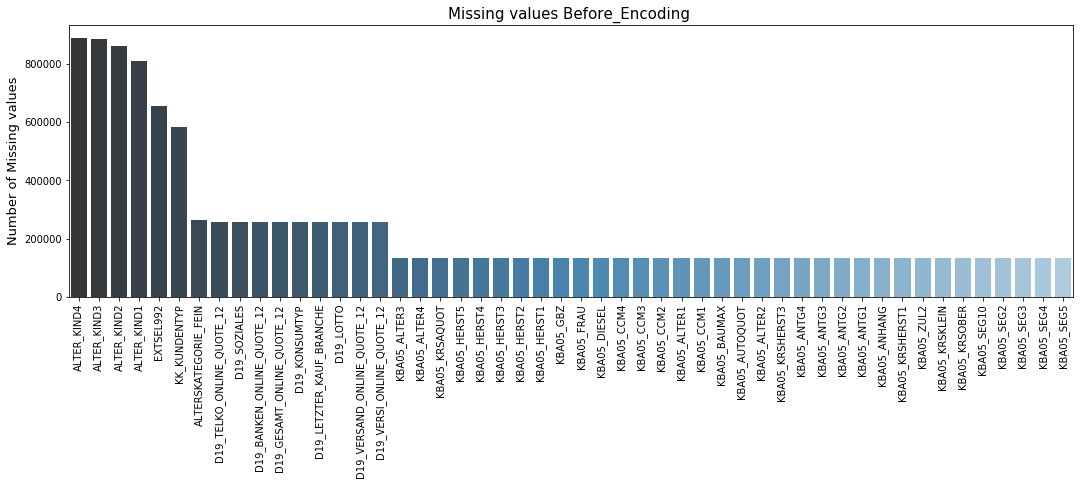

In [20]:
from helpers import missing_values_barplt
missing_values_barplt(missing_df,'Before_Encoding')

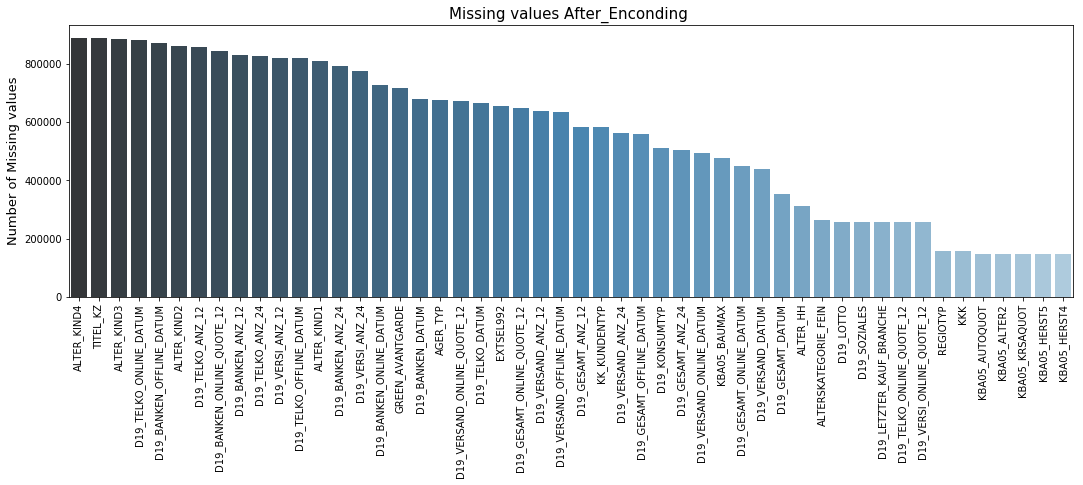

In [21]:
missing_values_barplt(missing_df,'After_Enconding')


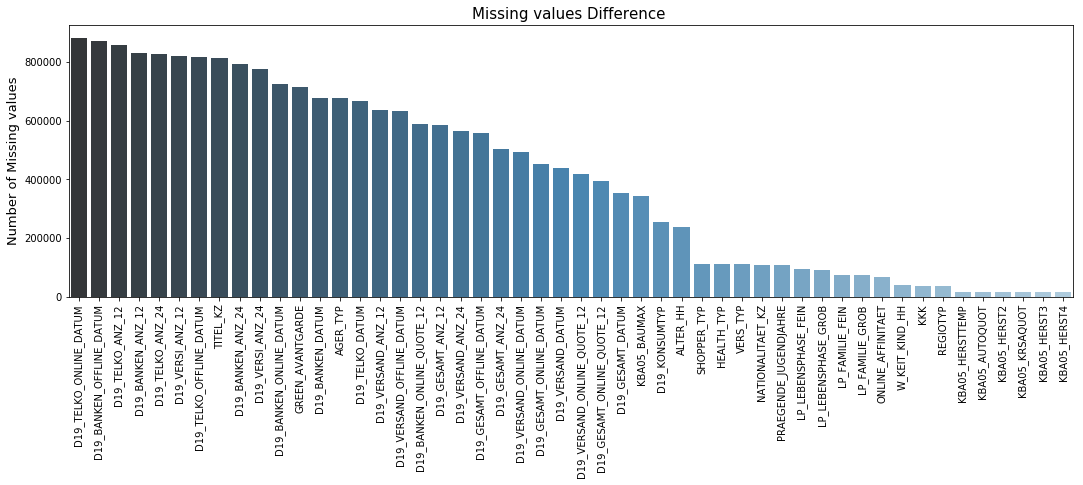

In [22]:
missing_values_barplt(missing_df,'Difference')

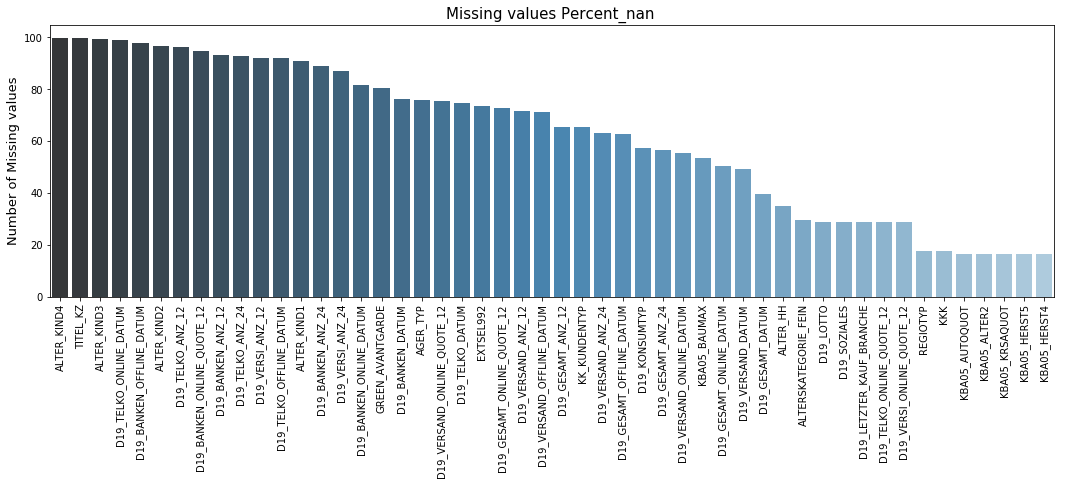

In [23]:
from helpers import missing_values_barplt
missing_values_barplt(missing_df,'Percent_nan')

The bar plots above show us that there are attributes with a lot of missing values after converting the missing value codes to nan variables. It's important to notice that some columns got a significant increase in missing values. Besides, the column AGER_TYP that has no missing values before the encoding, got tons of nan variables.

I will now check the distribution of the some attributes in order to find potencial outliers.


In [24]:
missing_more_than_40_pct = missing_df.loc[missing_df.Percent_nan >= 40, :].sort_values(by = ['Percent_nan'], ascending = False)

In [25]:
missing_more_than_40_pct

,Before_Encoding,After_Enconding,Difference,Percent_nan
ALTER_KIND4,890016.0,890016.0,0.0,99.864792
TITEL_KZ,73499.0,889061.0,815562.0,99.757636
ALTER_KIND3,885051.0,885051.0,0.0,99.307691
D19_TELKO_ONLINE_DATUM,0.0,883018.0,883018.0,99.079577
D19_BANKEN_OFFLINE_DATUM,0.0,871535.0,871535.0,97.791120
ALTER_KIND2,861722.0,861722.0,0.0,96.690047
D19_TELKO_ANZ_12,0.0,857990.0,857990.0,96.271295
D19_BANKEN_ONLINE_QUOTE_12,257113.0,845987.0,588874.0,94.924491
D19_BANKEN_ANZ_12,0.0,831734.0,831734.0,93.325225
D19_TELKO_ANZ_24,0.0,826208.0,826208.0,92.705176


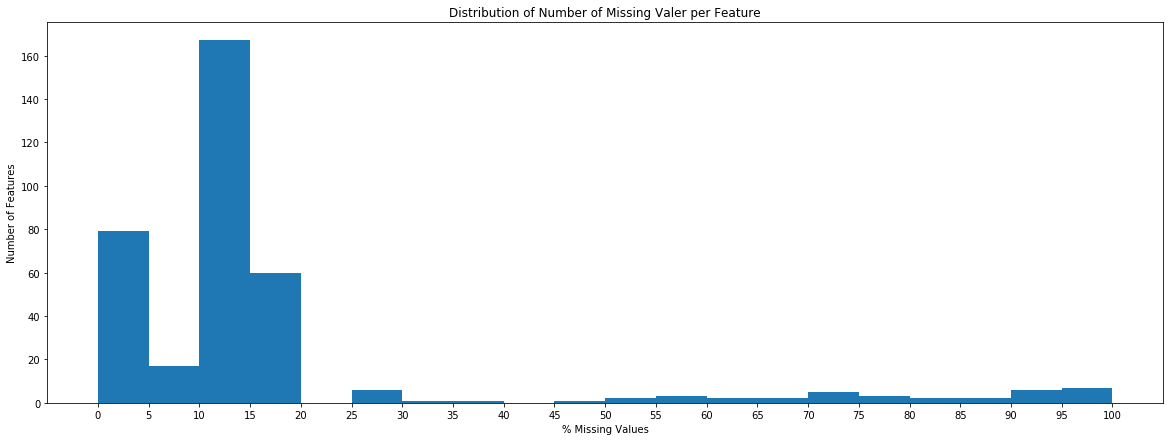

In [26]:
# Missing values histogram
from helpers import hist_missing_values
hist_missing_values(missing_df )

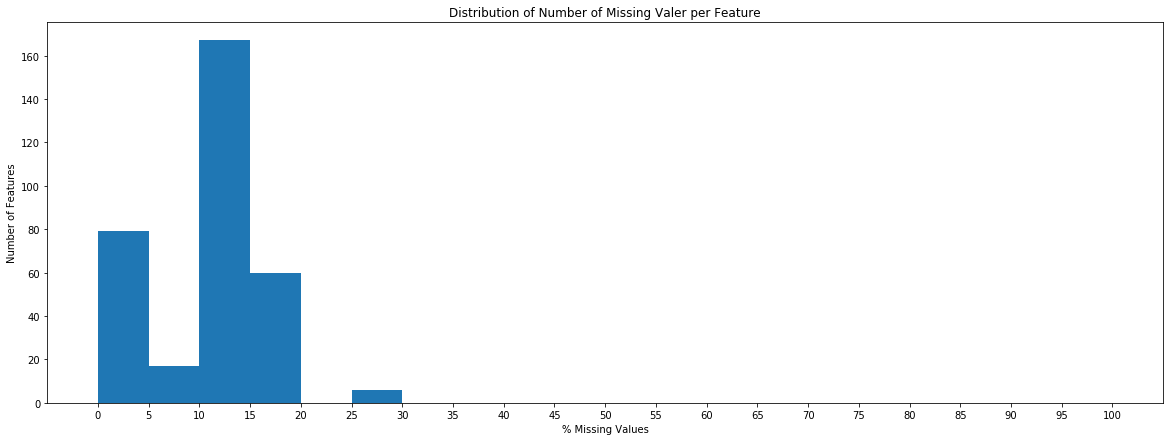

In [27]:
# missing values < 30 %
hist_missing_values(missing_df,threshold = 30,greater_or_less ='less' )

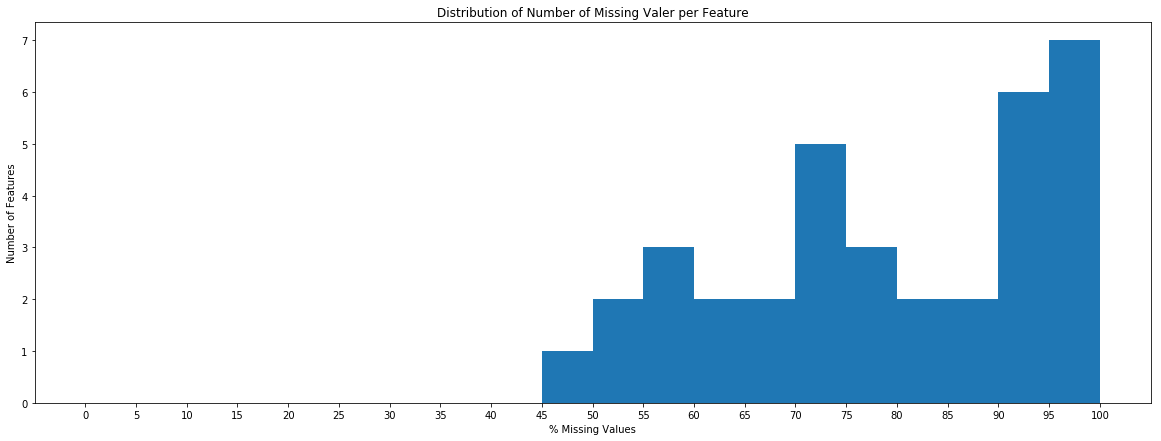

In [28]:
# missing values > 30%
hist_missing_values(missing_df,threshold = 40,greater_or_less ='greater' )

In [29]:
threshold = [10,20,30,40,50,50,60]
print('Missing Values Per Features:')
print()
for i in threshold:
    outliers = missing_df[missing_df['Percent_nan'] > i]
    print('Features with more than {}% of missing values: {}'.format(i,outliers.shape[0]))

Missing Values Per Features:

Features with more than 10% of missing values: 270
Features with more than 20% of missing values: 43
Features with more than 30% of missing values: 37
Features with more than 40% of missing values: 35
Features with more than 50% of missing values: 34
Features with more than 50% of missing values: 34
Features with more than 60% of missing values: 29


In [30]:
azdias_after_encoding.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [31]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

## 1.4 Removing Features 

The distributions above show us that most of the features of the dataset have zero or small amount of missing values. In addition to that, we can notice that 35 featues have more than 40% of missing values. It seems reasonable to delete those columns since those features with high amount of missing values do note give us much information.


In [32]:
missing_more_than_40_pct.head()


,Before_Encoding,After_Enconding,Difference,Percent_nan
ALTER_KIND4,890016.0,890016.0,0.0,99.864792
TITEL_KZ,73499.0,889061.0,815562.0,99.757636
ALTER_KIND3,885051.0,885051.0,0.0,99.307691
D19_TELKO_ONLINE_DATUM,0.0,883018.0,883018.0,99.079577
D19_BANKEN_OFFLINE_DATUM,0.0,871535.0,871535.0,97.791120


In [33]:
print('features with more than 40% missing values:',missing_more_than_40_pct.shape[0])

features with more than 40% missing values: 35


In [34]:
azdias.shape

(891221, 366)

In [35]:
azdias_after_encoding.shape

(891221, 366)

In [36]:
missing_more_than_40_pct.head()

,Before_Encoding,After_Enconding,Difference,Percent_nan
ALTER_KIND4,890016.0,890016.0,0.0,99.864792
TITEL_KZ,73499.0,889061.0,815562.0,99.757636
ALTER_KIND3,885051.0,885051.0,0.0,99.307691
D19_TELKO_ONLINE_DATUM,0.0,883018.0,883018.0,99.079577
D19_BANKEN_OFFLINE_DATUM,0.0,871535.0,871535.0,97.791120


In [37]:
print('Dataframe before the columns removal:',azdias_after_encoding.shape)

Dataframe before the columns removal: (891221, 366)


In [38]:
columns_to_drop = [x for x in missing_more_than_40_pct.index]
azdias_dropped_features = azdias_after_encoding.drop(columns_to_drop, axis =1 )

In [39]:
columns_to_drop

['ALTER_KIND4',
 'TITEL_KZ',
 'ALTER_KIND3',
 'D19_TELKO_ONLINE_DATUM',
 'D19_BANKEN_OFFLINE_DATUM',
 'ALTER_KIND2',
 'D19_TELKO_ANZ_12',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_BANKEN_ANZ_12',
 'D19_TELKO_ANZ_24',
 'D19_VERSI_ANZ_12',
 'D19_TELKO_OFFLINE_DATUM',
 'ALTER_KIND1',
 'D19_BANKEN_ANZ_24',
 'D19_VERSI_ANZ_24',
 'D19_BANKEN_ONLINE_DATUM',
 'GREEN_AVANTGARDE',
 'D19_BANKEN_DATUM',
 'AGER_TYP',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'D19_TELKO_DATUM',
 'EXTSEL992',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_VERSAND_ANZ_12',
 'D19_VERSAND_OFFLINE_DATUM',
 'D19_GESAMT_ANZ_12',
 'KK_KUNDENTYP',
 'D19_VERSAND_ANZ_24',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_KONSUMTYP',
 'D19_GESAMT_ANZ_24',
 'D19_VERSAND_ONLINE_DATUM',
 'KBA05_BAUMAX',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_VERSAND_DATUM']

In [40]:
print('Dataframe after the columns removal:',azdias_dropped_features.shape) 

Dataframe after the columns removal: (891221, 331)


### Part 1.5 Missing values per row after the outlier columns removal


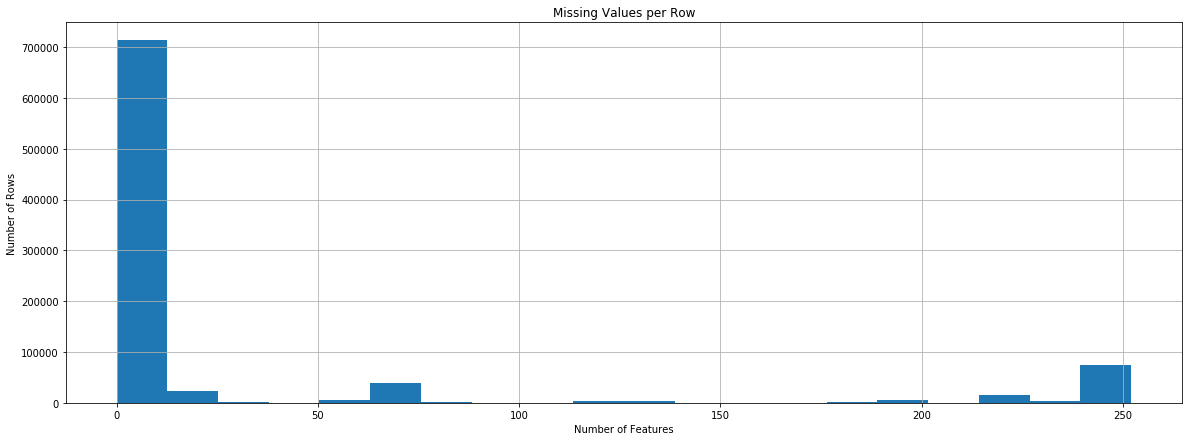

In [41]:
fig = plt.figure(figsize=(20,7))
azdias_dropped_features.isnull().sum(axis=1).hist(bins=20)
plt.title('Missing Values per Row');
plt.xlabel('Number of Features')
plt.ylabel('Number of Rows');

In [42]:
# percentage of missing value for rows with about 240 nan variables
round(250/azdias_dropped_features.shape[1],2)

0.76

Let's now consider the number of missing values per row. Looking at the distribution above, we can see that there are rows with more than 250 missing values. This represents about 76% of nan varibles in the rows. So, in order to analyse those rows I will split the dataframe into two. The first will have less missing values than a specified threshold and the second will have the number of missing values greater than this threshold. Than, I will analyse the distribution of those groups and check if they are too different from one another. If so,I will be comfortable dropping those rows from my dataframe.


In [43]:
# Split dataframe 
df_new = azdias_dropped_features.copy()

df_low_missing_values = df_new.dropna(thresh= 250) # Keep only the rows with at least 250 non-NA values


df_high_missing = df_new[~df_new.index.isin(df_low_missing_values.index)]

df_low_missing_values.shape, df_high_missing.shape 

((784776, 331), (106445, 331))

In [44]:
def compare_df_plot(df_low_missing, df_high_missing, column_names):
    
    for column_name in column_names:
    
        fig = plt.figure(figsize = (15,5))
        ax1 = fig.add_subplot(121)
        ax1.title.set_text('Low Missing Values')
        sns.countplot(df_low_missing.loc[:, column_name])

        ax2 = fig.add_subplot(122)
        ax2.title.set_text('High Missing Values')
        sns.countplot(df_high_missing.loc[:,column_name])      
        
        #fig.subtitle(column_name)
        plt.plot()

In [65]:
from helpers import compare_df_plot

In [45]:
columns = ['ANREDE_KZ','FINANZTYP','ZABEOTYP', 'SEMIO_TRADV', 'FINANZ_VORSORGER', 'FINANZTYP', 'ALTERSKATEGORIE_GROB', 'ONLINE_AFFINITAET']

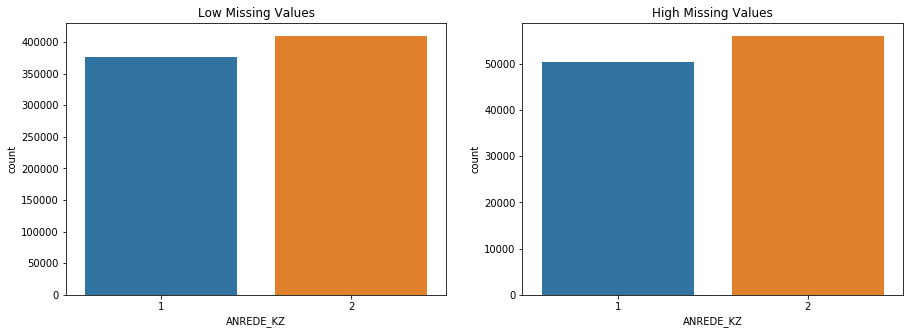

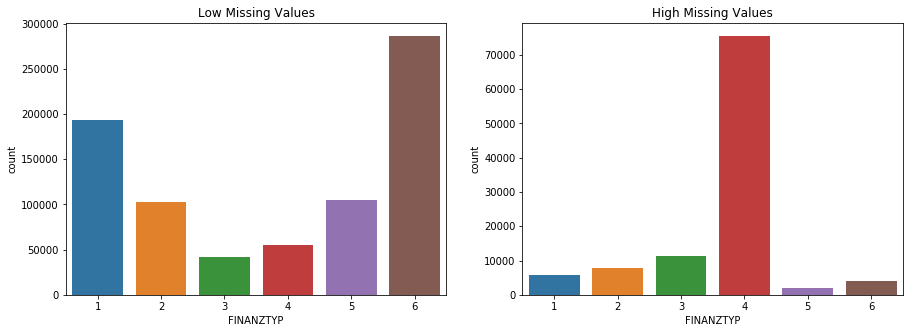

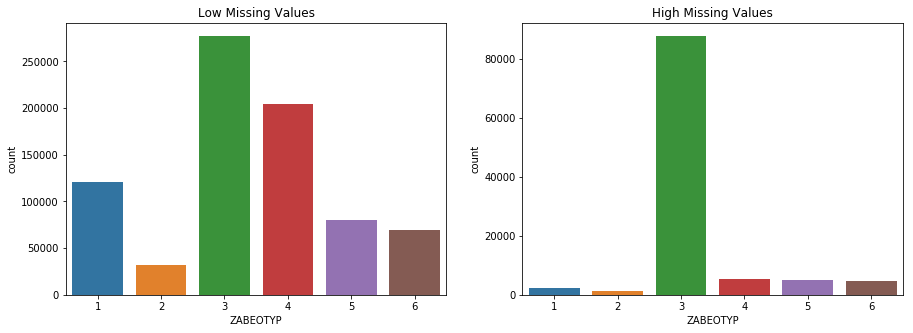

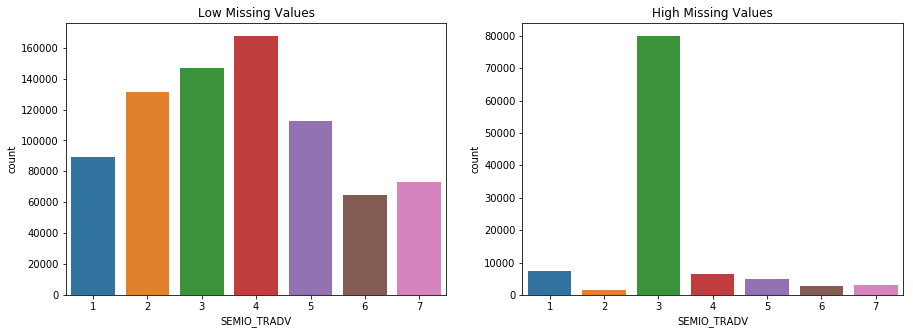

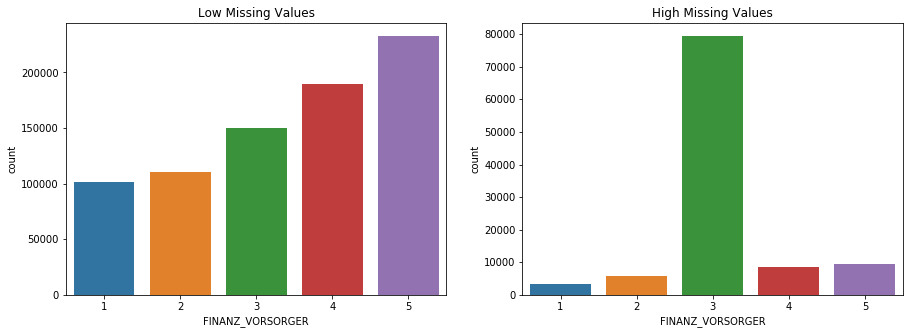

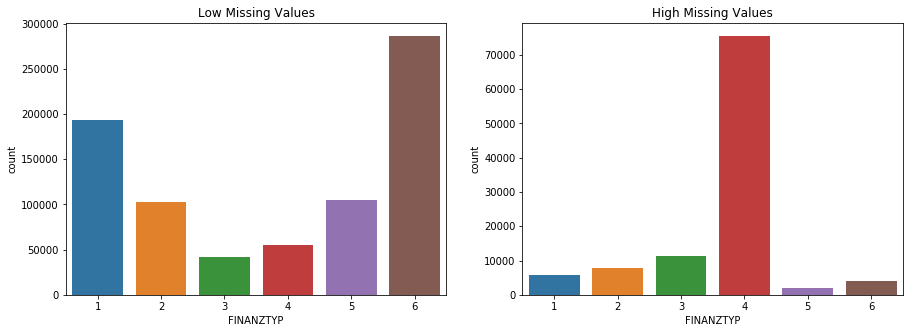

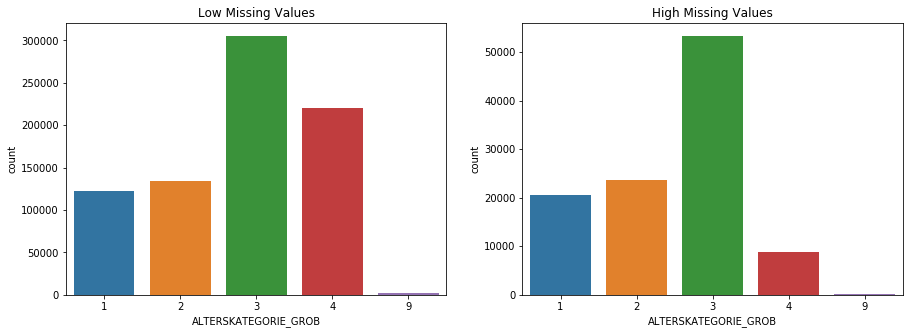

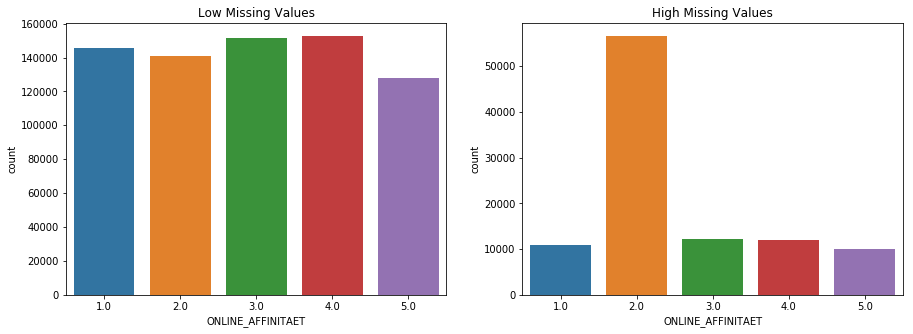

In [46]:
compare_df_plot(df_low_missing_values , df_high_missing ,columns)

In [47]:
import random
#sampling with replacement

sampling = random.choices(azdias_dropped_features.columns, k=5)
print("Randomly selected multiple columns: \n ", sampling)

Randomly selected multiple columns: 
  ['D19_SCHUHE', 'KBA13_HALTER_30', 'D19_DROGERIEARTIKEL', 'KBA05_ANTG3', 'REGIOTYP']


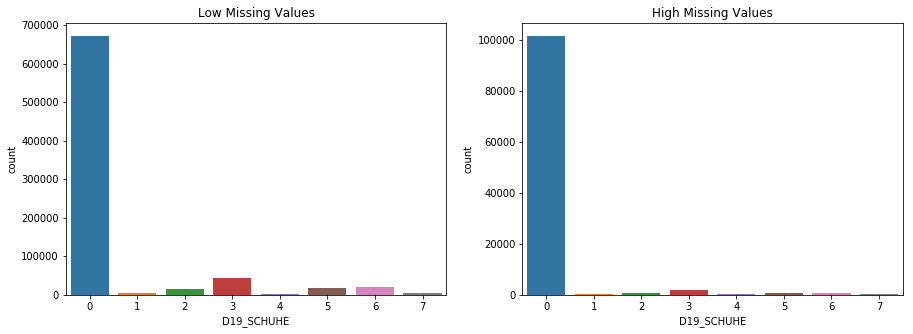

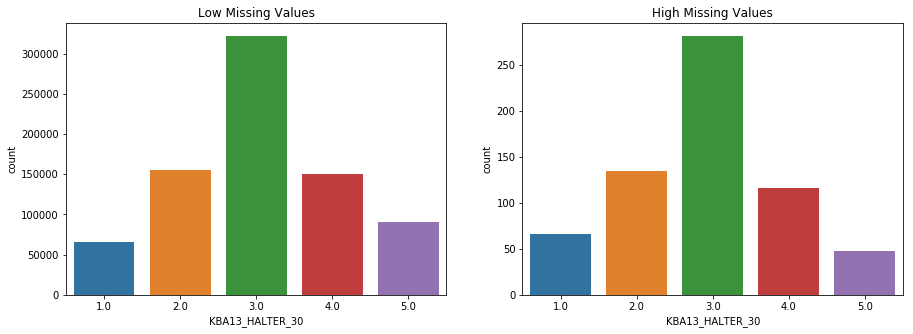

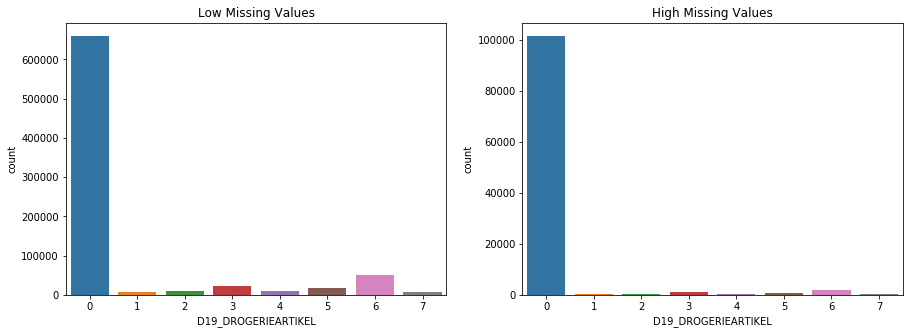

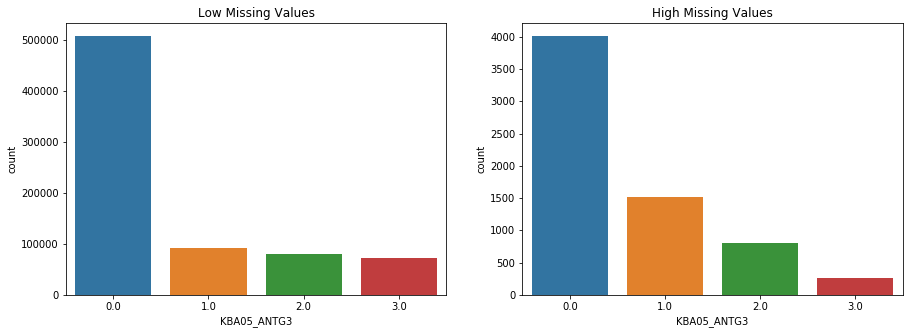

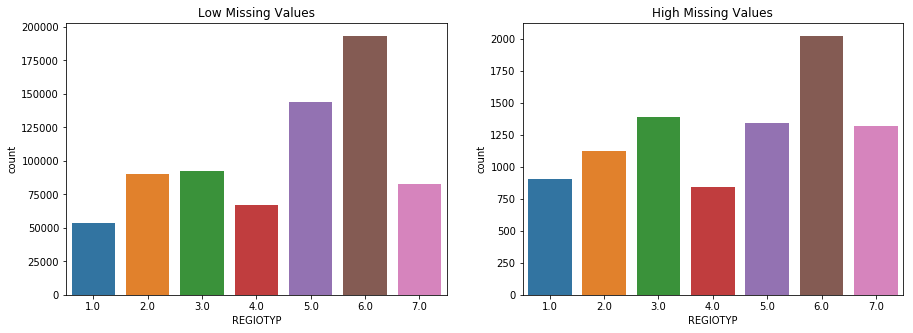

In [49]:
compare_df_plot(df_low_missing_values , df_high_missing ,sampling)


We can notice that some features  have distribution completely different from the dataframe with smaller amount of missing value.This suggests that these two groups are different from one another.Based on that, from now on, I will keep working with the low_missing_values data frame.

## Feature Engineering

The unsupervised learning algorithm that will be used to build the customer segmentation, requires numerical values. Because of that, all the data must be numeric encoded so that the model can proceed the way it is supposed to proceed.



In [ ]:
# drop LNR columns - it looks to be just an identifier 
#df_low_missing_values.drop(['LNR'] ,axis =1 , inplace = True)

The above dictionaries contains the binary features and the multiple features. This helps to identify the columns that will need to be better investigated so that we can encode them correctly.

In [55]:
from helpers import unique_values_dict
binary_variable , multiple_categorical_feature = unique_values_dict(df_low_missing_values)


In [56]:
print('============ BINARY FEATURES: =============\n')
print('\n'.join('column: {} Unique Values: {}'.format(key,value) for key,value in binary_variable.items()))




============ BINARY FEATURES: =============

column: DSL_FLAG Unique Values: 2
column: HH_DELTA_FLAG Unique Values: 2
column: KBA05_SEG6 Unique Values: 2
column: KONSUMZELLE Unique Values: 2
column: OST_WEST_KZ Unique Values: 2
column: SOHO_KZ Unique Values: 2
column: UNGLEICHENN_FLAG Unique Values: 2
column: VERS_TYP Unique Values: 2
column: ANREDE_KZ Unique Values: 2


In [57]:
df_low_missing_values.OST_WEST_KZ.unique()

array(['W', 'O'], dtype=object)

The only benary feature that needs to be encoded is OST_WEST_KZ
* array(['W', 'O'], dtype=object)

In [58]:
print('========= MULTIPLE VALUES FEATURES: ==========\n')
print('\n'.join('column: {} Unique Values: {}'.format(key,value) for key,
                value in multiple_categorical_feature.items()))

========= MULTIPLE VALUES FEATURES: ==========

column: LNR Unique Values: 784776
column: AKT_DAT_KL Unique Values: 9
column: ALTER_HH Unique Values: 21
column: ALTERSKATEGORIE_FEIN Unique Values: 26
column: ANZ_HAUSHALTE_AKTIV Unique Values: 292
column: ANZ_HH_TITEL Unique Values: 20
column: ANZ_KINDER Unique Values: 11
column: ANZ_PERSONEN Unique Values: 29
column: ANZ_STATISTISCHE_HAUSHALTE Unique Values: 263
column: ANZ_TITEL Unique Values: 5
column: ARBEIT Unique Values: 6
column: BALLRAUM Unique Values: 7
column: CAMEO_DEU_2015 Unique Values: 45
column: CAMEO_DEUG_2015 Unique Values: 19
column: CAMEO_INTL_2015 Unique Values: 43
column: CJT_GESAMTTYP Unique Values: 6
column: CJT_KATALOGNUTZER Unique Values: 5
column: CJT_TYP_1 Unique Values: 5
column: CJT_TYP_2 Unique Values: 5
column: CJT_TYP_3 Unique Values: 5
column: CJT_TYP_4 Unique Values: 5
column: CJT_TYP_5 Unique Values: 5
column: CJT_TYP_6 Unique Values: 5
column: D19_BANKEN_DIREKT Unique Values: 8
column: D19_BANKEN_GROS

In [59]:
np.sort(df_low_missing_values.AKT_DAT_KL.unique())

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [60]:
#Object features 
obj_features = df_low_missing_values.select_dtypes(include = ['object']).columns
obj_features

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object')

In [61]:
# Unique values fperfeature
for k,v in multiple_categorical_feature.items():
    
    print(k,'\n','Unique value :', end=' ')
    
    if k in list(obj_features): # skip object type features 
        pass
    else:
        print(np.sort(df_low_missing_values[k].unique()))
        
    
    

LNR 
 Unique value : [ 191653  191654  191657 ..., 1082871 1082872 1082873]
AKT_DAT_KL 
 Unique value : [ 1.  2.  3.  4.  5.  6.  7.  8.  9.]
ALTER_HH 
 Unique value : [  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  nan]
ALTERSKATEGORIE_FEIN 
 Unique value : [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  nan]
ANZ_HAUSHALTE_AKTIV 
 Unique value : [   0.    1.    2.    3.    4.    5.    6.    7.    8.    9.   10.   11.
   12.   13.   14.   15.   16.   17.   18.   19.   20.   21.   22.   23.
   24.   25.   26.   27.   28.   29.   30.   31.   32.   33.   34.   35.
   36.   37.   38.   39.   40.   41.   42.   43.   44.   45.   46.   47.
   48.   49.   50.   51.   52.   53.   54.   55.   56.   57.   58.   59.
   60.   61.   62.   63.   64.   65.   66.   67.   68.   69.   70.   71.
   72.   73.   74.   75.   76.   77.   78.   79.   80.   81.   82.  

 Unique value : [ 1.  2.  3.  4.  5.  6.  8.]
GEBAEUDETYP_RASTER 
 Unique value : [  1.   2.   3.   4.   5.  nan]
GEBURTSJAHR 
 Unique value : [   0 1900 1902 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915
 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930
 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945
 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960
 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975
 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990
 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]
GEMEINDETYP 
 Unique value : [ 11.  12.  21.  22.  30.  40.  50.  nan]
GFK_URLAUBERTYP 
 Unique value : [  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  nan]
HEALTH_TYP 
 Unique value : [  1.   2.   3.  nan]
HH_EINKOMMEN_SCORE 
 Unique value : [ 1.  

 Unique value : [ 0.  1.  2.  3.  4.  5.]
KBA13_KW_50 
 Unique value : [ 0.  1.  2.  3.  4.  5.]
KBA13_KW_60 
 Unique value : [ 0.  1.  2.  3.  4.  5.]
KBA13_KW_61_120 
 Unique value : [ 1.  2.  3.  4.  5.]
KBA13_KW_70 
 Unique value : [ 0.  1.  2.  3.  4.  5.]
KBA13_KW_80 
 Unique value : [ 0.  1.  2.  3.  4.  5.]
KBA13_KW_90 
 Unique value : [ 0.  1.  2.  3.  4.  5.]
KBA13_MAZDA 
 Unique value : [ 1.  2.  3.  4.  5.]
KBA13_MERCEDES 
 Unique value : [ 1.  2.  3.  4.  5.]
KBA13_MOTOR 
 Unique value : [ 1.  2.  3.  4.]
KBA13_NISSAN 
 Unique value : [ 1.  2.  3.  4.  5.]
KBA13_OPEL 
 Unique value : [ 1.  2.  3.  4.  5.]
KBA13_PEUGEOT 
 Unique value : [ 1.  2.  3.  4.  5.]
KBA13_RENAULT 
 Unique value : [ 1.  2.  3.  4.  5.]
KBA13_SEG_GELAENDEWAGEN 
 Unique value : [ 1.  2.  3.  4.  5.]
KBA13_SEG_GROSSRAUMVANS 
 Unique value : [ 1.  2.  3.  4.  5.]
KBA13_SEG_KLEINST 
 Unique value : [ 1.  2.  3.  4.  5.]
KBA13_SEG_KLEINWAGEN 
 Unique value : [ 1.  2.  3.  4.  5.]
KBA13_SEG_KOMPAKTKLASSE 


Analysing each feature and its unique values, we can see that most of the features are already encoded.Even though there are ordinal and nominal variables in the dataset, it seems that categorizing them as been of the same type (categorical) will not cause huge inpact on the model. Becaus of that, I will assume all variables as being categorical. 

In [62]:
#Object features 
obj_features

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object')

**After analysing all of those features, I decided to do as follows:**
* **OST_WEST_KZ** binary feature that will bee re-encoded to 0 and 1
* **LNR** - It seems to be a index so we can get rid of it
* **CAMEO_DEU_2015** - This feature has many rows with 'XX' category (347 rows). I will consider those inputs as missing values and replace with a numerical value and apply one hot encode to re-encode the variable.
* **CAMEO_DEUG_2015** - This feature also has many 'X' inputs. I will do the same as the above feature
* **CAMEO_INTL_2015** - Same as above feature
* **D19_LETZTER_KAUF_BRANCHE** - This feature has 36 categories (strings) and needs to be re-encoded.  
* **EINGEFUEGT_AM** - It is a date format feature and needs to be re-enconded (year and month columns)

In order to avoid sparcity issues, I will limit the one hot encode to the 44 and 33 most frequent labels of the feature.In other words, I will make one binary variable for each of the 44 and 33 most frequent features categories only and consider the rest as noise. I will set the top 44 categories of variables **CAMEO_DEU_2015** and **CAMEO_INTL_2015** and top 33 of **D19_LETZTER_KAUF_BRANCHE**


I will use the top 44 and top 33 most frequent categories because that way I can carantee that all top components of azdias datafram are iqual to the top components of the customers dataframe. 


In [13]:
# Determine the number of top components that apears in both dataframes

In [15]:
# Determine the number of top components that apears in both dataframes
for key, value in customers.CAMEO_DEU_2015.value_counts()[:44].iteritems():
    if key in azdias.CAMEO_DEU_2015.value_counts()[:44].keys():
        pass
    else:
        print(key)

In [16]:
# Determine the number of top components that apears in both dataframes
for key, value in customers.D19_LETZTER_KAUF_BRANCHE.value_counts()[:44].iteritems():
    if key in azdias.D19_LETZTER_KAUF_BRANCHE.value_counts()[:44].keys():
        pass
    else:
        print(key)

In [18]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')


In [8]:
from helpers import clean_df
clean_azdias = clean_df(azdias, missing_code_df)

======================== WORKING ON AZDIAS DATAFRAME ===================================
============================= Drop index LNR ============================================

shape after removing LNR columns:  (891221, 365)
========================== Converte Missing Code ========================================

shape after converting missing code:  (891221, 365)
=================== Drop Features with more than 40% of missing values ==================

shape after dropping all columns with more than 40% of missing values:  (891221, 330)
============================= Delete Columns ============================================

shape after dropping rows with more thab 250 missing values:  (784541, 330)
=================== Impute the missing values (impute most frequent value) ==============

Shape after imputation  (784541, 330)
====================== Re-encode binary fature (OST_WEST_KZ) ============================

Shape after reencoding OST_WEST_KZ column, (784541, 330)
=======

In [10]:
display(clean_azdias.shape)
display(clean_azdias.head(10))

(784541, 427)

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_DATUM,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_MOBILE,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_REST,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,...,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KOMBIALTER,KONSUMNAEHE,KONSUMZELLE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_RASTER,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,PRAEGENDE_JUGENDJAHRE,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRAD

In [2]:
# load in the data
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [15]:
#customers.head()


In [114]:
from helpers import clean_df
clean_customers = clean_df(customers, missing_code_df, clean_azdias.columns , is_customer_df =True)

======================== WORKING ON CUSTOMER DATAFRAME =================================
====== Delete CUSTOMER_GROUP, ONLINE_PURCHASE, PRODUCT_GROUP features ===============

shape after removing 3 columns:  (191652, 366)
============================= Drop index LNR ============================================

shape after removing LNR columns:  (191652, 365)
========================== Converte Missing Code ========================================

shape after converting missing code:  (191652, 365)
=================== Drop Features with more than 40% of missing values ==================

shape after dropping all columns with more than 40% of missing values:  (191652, 330)
============================= Delete Columns ============================================


shape after dropping rows with more thab 250 missing values:  (140277, 330)
=================== Impute the missing values (impute most frequent value) ==============


Shape after imputation  (140277, 330)
===================

In [12]:
display(clean_customers.shape)
display(clean_customers.head(10))

(140277, 427)

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_DATUM,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_MOBILE,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_REST,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,...,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KOMBIALTER,KONSUMNAEHE,KONSUMZELLE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_RASTER,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,PRAEGENDE_JUGENDJAHRE,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRAD

Let's dump the cleaned dataframes to pickle objects

In [54]:
# Dump the azdias dataframe to a pickle object 
#pickle.dump(clean_azdias, open("clean_azdias.pickle", "wb"))

# Dump the clean_customers dataframe to a pickle object 
#pickle.dump(clean_customers, open("clean_customers.pickle", "wb"))

## Part 2: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

load the cleaned dataframes :

In [4]:
# Reload clean_customers object 
clean_customers = pickle.load(open("clean_customers.pickle", "rb"))

In [113]:
# Reload clean_azdias object 
clean_azdias = pickle.load(open("clean_azdias.pickle", "rb"))

In [6]:
clean_azdias.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_DATUM,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_MOBILE,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_REST,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,...,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KOMBIALTER,KONSUMNAEHE,KONSUMZELLE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_RASTER,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,PRAEGENDE_JUGENDJAHRE,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRAD

### Part 2.1 Feature Scaling

Since we have a large dataset, we will perform a dimensionality reduction. To do so, we need to perform a feature scaling so that the principal component vector will not be influenced by the difference in scale of each variable. This apporach is really important when dealing with distance based algorithms, wich is our case.

I will use StandarScale that scale each feature to mean 0 and standard deviation iquals to 1.



In [74]:
#scaler obj
scaler = StandardScaler()

#scale dataframe
scaled_azdias = scaler.fit_transform(clean_azdias.astype(float))

In [75]:
#create scaled dataframe
azdias_scaled_df = pd.DataFrame(data=scaled_azdias, 
                             index= clean_azdias.index, 
                             columns=clean_azdias.columns)


In [10]:
print('Shape of clean_azdias dataframe:', clean_azdias.shape)
print()
print('Shape of scaled_azdias_df', azdias_scaled_df.shape)
print()
display(azdias_scaled_df.head(3))

Shape of clean_azdias dataframe: (784541, 427)

Shape of scaled_azdias_df (784541, 427)



,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_DATUM,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_MOBILE,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_REST,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,...,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KOMBIALTER,KONSUMNAEHE,KONSUMZELLE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_RASTER,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,PRAEGENDE_JUGENDJAHRE,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRAD

In [10]:
# Reload clean_azdias object 
azdias_scaled_df = pickle.load(open("azdias_scaled_df.pickle", "rb"))

## Part 2.2 Dimensionality Reduction (PCA)


Now that we have the scaled data frame  we can apply dimensionality reduction. To do that, I will use the principal component approach in order to find the vectors of maximal variance in the data. To start off, all the features of the dataframe will be kept. That way, we can see the general trend in variability. I will plot a graph showing the ratio of variance explained by each component and the cumulative variance explained. After that, I will select the number of transformed features I will retain for the clustering part of the project. 

In [32]:
# PCA obj
pca = PCA()

azdias_pca_df = pca.fit_transform(azdias_scaled_df)

In [36]:
# Investigate the variance explained by each principal component
var = pca.explained_variance_ratio_

# number of total components
n_components = len(pca.explained_variance_ratio_)

cumulative_sum_var = np.cumsum(np.round(pca.explained_variance_ratio_,
                              decimals = 3)*100)


In [42]:
display('number of components',n_components)
display(cumulative_sum_var[:100])

'number of components'

427

array([  6.7,  10.9,  14.6,  17.3,  19.3,  21. ,  22.6,  24.1,  25.4,
        26.6,  27.7,  28.7,  29.6,  30.4,  31.2,  32. ,  32.8,  33.5,
        34.2,  34.9,  35.6,  36.2,  36.8,  37.4,  38. ,  38.5,  39. ,
        39.5,  40. ,  40.5,  41. ,  41.5,  42. ,  42.5,  43. ,  43.5,
        44. ,  44.5,  45. ,  45.5,  46. ,  46.5,  47. ,  47.5,  48. ,
        48.5,  49. ,  49.4,  49.8,  50.2,  50.6,  51. ,  51.4,  51.8,
        52.2,  52.6,  53. ,  53.4,  53.8,  54.2,  54.6,  54.9,  55.2,
        55.5,  55.8,  56.1,  56.4,  56.7,  57. ,  57.3,  57.6,  57.9,
        58.2,  58.5,  58.8,  59.1,  59.4,  59.7,  60. ,  60.3,  60.6,
        60.9,  61.2,  61.5,  61.8,  62.1,  62.4,  62.7,  63. ,  63.3,
        63.6,  63.9,  64.2,  64.5,  64.8,  65.1,  65.4,  65.7,  66. ,  66.2])

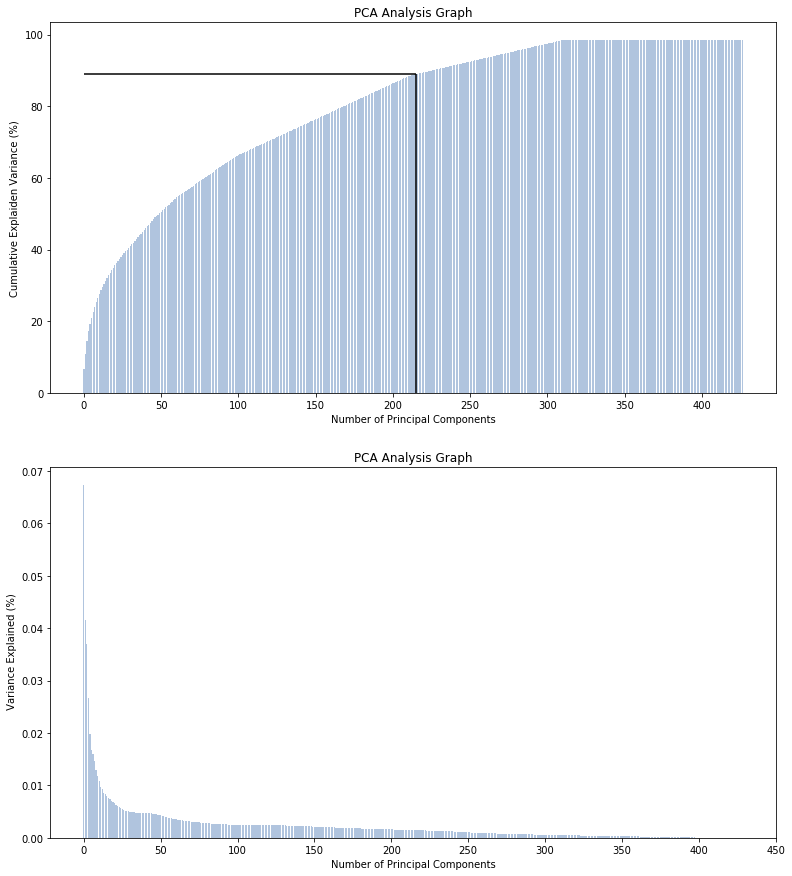

In [63]:
# PCA analysis
#from helpers import pca_analysis_plot
index = np.arange(n_components)
values = pca.explained_variance_ratio_
pca_analysis_plot(n_conponents= n_components, 
             index= index, 
             var_values = values,
             cum_sum = cumulative_sum_var)

After looking at the variance explained by each component in the screen plots above, I decided to select 215 components, which account for about 89% of the variance explaided. 

## Part 2.3 Interpret Principal Components

After seeing the components that account for a large percentage of the data variance and determine the number of components to be used, we can check out the weights given to each variable on the first few components. 

In order to understand the results of the dimensionality reduction, we have to bear in mind that each eigenvector ( principal component) is made of a weighted linear combination of the original features and spans the direction of the most variation. Also,the further a weight is from zero, the more the principal component is in the direction of the corresponding feature. Two features with large weights of the same sign tend to related in a way that an increase in one of them results in an increase in the other. To contrast, features with different signs are expected to have a negative correlation. In other words, increase in one vairiable should result in a decrease in the other.

I will map each weight to its correspond feature name and then sorte the features according to the value of the weights. I will analyse the first and last 5 features that are those with highest and lowest weight values respectively.






In [11]:
# Number of componetes I selected
n_components = 215

# New pca
pca = PCA(n_components)

azdias_pca = pca.fit_transform(azdias_scaled_df)

In [12]:
# Dump the pca  to a pickle object 
pickle.dump(pca, open("pca.pickle", "wb"))

In [13]:
azdias_pca

array([[ 4.63687707,  5.12982862,  5.99278309, ...,  0.61886451,
         0.81304216,  0.86687912],
       [-0.77577292,  2.45899479,  1.20935911, ...,  0.59220502,
        -0.05168615, -0.70005583],
       [-5.88976372,  1.08841439, -2.73120615, ...,  0.01694796,
         0.24723519, -0.5821013 ],
       ..., 
       [-3.60912225,  0.35080963,  6.25182864, ...,  0.53536839,
        -1.49825359, -0.41272984],
       [ 7.9346944 , -4.85075504,  4.31070217, ...,  0.14804325,
         1.21789077, -0.14622809],
       [-0.88680304, -0.21224813, -3.98358374, ...,  0.24449838,
        -0.66049341,  0.20130107]])

In [ ]:
# Dump azdias_pca to a pickle object 
#pickle.dump(azdias_pca, open("azdias_pca.pickle", "wb"))

In [ ]:
azdias_scaled_df.head()

In [10]:
azdias_scaled_df.shape

(784541, 391)

In [14]:
# import functions from helpers.py file
from helpers import plot_pca
from helpers import explained_variance_and_weights_df

,Explained_variance
Dimension: 1,0.0673


,KBA13_ANTG3,PLZ8_ANTG3,KBA13_ANTG4,KBA13_BAUMAX,PLZ8_ANTG4,PLZ8_BAUMAX,CAMEO_DEUG_2015,HH_EINKOMMEN_SCORE,EWDICHTE,ORTSGR_KLS9,FINANZ_HAUSBAUER,PLZ8_ANTG2,CAMEO_INTL_2015_51.0,ARBEIT,KBA13_HALTER_30,KBA05_ANTG4,KBA13_HALTER_35,STRUKTURTYP,KBA05_ANTG3,VK_DISTANZ,ZABEOTYP,RELAT_AB,KONSUMZELLE,ANZ_HAUSHALTE_AKTIV,ANZ_STATISTISCHE_HAUSHALTE,VK_DHT4A,VK_ZG11,KBA13_ANTG2,D19_KONSUMTYP_MAX,CJT_TYP_2,D19_GESAMT_DATUM,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,KBA13_ALTERHALTER_30,AKT_DAT_KL,FINANZ_SPARER,KBA13_BJ_2000,W_KEIT_KIND_HH,CJT_TYP_1,CAMEO_DEU_2015_8A,D19_VERSI_DATUM,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,KBA13_VORB_3,KBA05_ZUL1,CAMEO_DEU_2015_9B,KBA13_ALTERHALTER_45,KBA13_HERST_SONST,KBA13_FAB_SONSTIGE,KBA13_KW_0_60,KBA13_NISSAN,KBA13_HALTER_40,GEBAEUDETYP,EINGEZOGENAM_HH_JAHR,KBA13_SEG_KOMPAKTKLASSE,RT_KEIN_ANREIZ,SEMIO_PFLICHT,SEMIO_REL,KBA13_CCM_0_1400,VHN,KBA13_HERST_EUROPA,KBA13_RENAULT,KBA05_VORB2,KBA13_BJ_1999,KBA05_ALTER1,KBA13_HERST_ASIEN,KBA13_MAZDA,KBA13_SEG_SONSTIGE,VERDICHTUNGSRAUM,REGIOTYP,GFK_URLAUBERTYP,CAMEO_INTL_2015_41.0,SEMIO_FAM,SEMIO_MAT,KBA05_MAXHERST,PRAEGENDE_JUGENDJAHRE,KBA05_KW1,KBA05_MAXVORB,SEMIO_RAT,CAMEO_DEU_2015_8B,KBA13_HHZ,KBA13_KMH_180,CAMEO_INTL_2015_54.0,KBA13_SEG_KLEINST,KBA13_KW_40,KBA13_KMH_0_140,KBA13_VORB_2,NATIONALITAET_KZ,PLZ8_HHZ,KBA13_CCM_1000,SEMIO_KAEM,ALTERSKATEGORIE_FEIN,KBA05_CCM1,CAMEO_INTL_2015_55.0,KBA13_CCM_1400,KBA13_HALTER_25,KKK,KBA13_KW_50,CAMEO_DEU_2015_9A,CAMEO_INTL_2015_52.0,CJT_KATALOGNUTZER,CAMEO_DEU_2015_8C,SEMIO_TRADV,SEMIO_KULT,KBA13_TOYOTA,VERS_TYP,CAMEO_DEU_2015_8D,KBA13_SEG_MITTELKLASSE,KBA13_SEG_KLEINWAGEN,KBA13_FAB_ASIEN,KBA05_HERST5,KBA13_PEUGEOT,KBA13_CCM_1200,ANZ_HH_TITEL,CAMEO_DEU_2015_7B,KBA13_SEG_MINIWAGEN,FINANZ_ANLEGER,KBA13_KRSSEG_KLEIN,HEALTH_TYP,KBA05_SEG3,SEMIO_SOZ,KBA13_KW_60,FINANZ_UNAUFFAELLIGER,D19_VERSI_OFFLINE_DATUM,KBA05_ALTER2,KBA13_KRSHERST_FORD_OPEL,KBA05_CCM2,KBA13_SITZE_5,KBA05_HERST4,CJT_GESAMTTYP,CAMEO_DEU_2015_9E,SEMIO_DOM,CAMEO_DEU_2015_7C,KBA13_FIAT,SEMIO_KRIT,KBA05_ANTG2,KBA13_HALTER_66,KBA05_KRSHERST3,RETOURTYP_BK_S,DSL_FLAG,CAMEO_INTL_2015_45.0,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_6E,KBA13_CCM_1600,KBA13_ALTERHALTER_61,KBA05_SEG2,ALTER_HH,KBA05_KRSKLEIN,KBA13_FORD,ANREDE_KZ,KBA13_KMH_140,CAMEO_DEU_2015_5D,KBA13_SEG_OBERKLASSE,CAMEO_DEU_2015_7A,D19_VERSI_ONLINE_DATUM,KBA13_SITZE_4,KBA13_KMH_140_210,CAMEO_DEU_2015_6A,CAMEO_INTL_2015_34.0,KBA13_KW_70,CAMEO_DEU_2015_6F,KBA13_KW_30,CAMEO_DEU_2015_7E,KBA05_HERST3,UMFELD_ALT,KBA13_SEG_OBEREMITTELKLASSE,CAMEO_DEU_2015_6D,CAMEO_INTL_2015_31.0,CAMEO_DEU_2015_6C,CAMEO_INTL_2015_44.0,KBA13_BMW,D19_LETZTER_KAUF_BRANCHE_D19_DIGIT_SERV,SHOPPER_TYP,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,CAMEO_DEU_2015_5E,D19_LETZTER_KAUF_BRANCHE_D19_REISEN,CAMEO_INTL_2015_35.0,CAMEO_DEU_2015_5A,KBA13_KMH_110,CAMEO_INTL_2015_0.0,SOHO_KZ,KBA05_HERSTTEMP,KBA05_FRAU,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_GROSS,ANZ_TITEL,KBA05_MOD3,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_LOKAL,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_REST,D19_LETZTER_KAUF_BRANCHE_D19_BIO_OEKO,D19_TELKO_ONLINE_QUOTE_12,D19_VERSI_ONLINE_QUOTE_12,D19_LETZTER_KAUF_BRANCHE_D19_BILDUNG,D19_LETZTER_KAUF_BRANCHE_D19_RATGEBER,CAMEO_DEU_2015_5F,D19_LETZTER_KAUF_BRANCHE_D19_HANDWERK,D19_LETZTER_KAUF_BRANCHE_D19_SAMMELARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_GARTEN,KBA05_MAXSEG,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,...,D19_LETZTER_KAUF_BRANCHE_D19_BEKLEIDUNG_GEH,D19_LETZTER_KAUF_BRANCHE_D19_ENERGIE,CAMEO_INTL_2015_33.0,CAMEO_DEU_2015_5C,KBA05_SEG1,CAMEO_DEU_2015_1E,D19_LETZTER_KAUF_BRANCHE_D19_BEKLEIDUNG_REST,KBA05_MOD2,D19_LETZTER_KAUF_BRANCHE_D19_DROGERIEARTIKEL,CAMEO_INTL_2015_32.0,CAMEO_DEU_2015_5B,KBA05_VORB1,CAMEO_DEU_2015_1A,D19_LETZTER_KAUF_BRANCHE_D19_SCHUHE,KBA13_KW_120,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,KOMBIALTER,KBA05_MOD4,KBA13_MERCEDES,KBA05_KRSVAN,KBA13_CCM_1500,KBA13_SEG_WOHNMOBILE,KBA05_ZUL2,CAMEO_DEU_2015_4B,D19_LETZTER_KAUF_BRANCHE_D19_BUCH_CD,KBA13_CCM_3000,KBA13_K

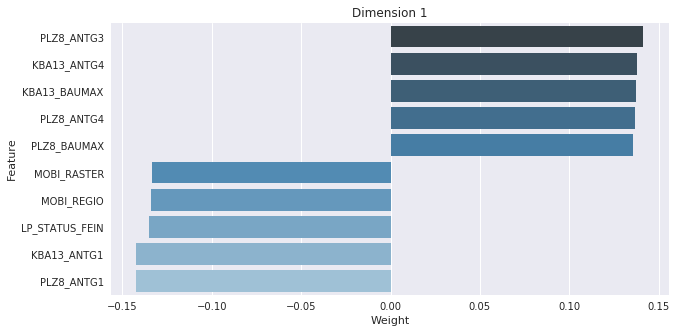

In [19]:
#Component 3
dimension_1_df , explained_variance_df = explained_variance_and_weights_df(azdias_scaled_df, pca, 0)
display(explained_variance_df)
display(dimension_1_df)
print()
plot_pca(dimension_1_df, num = 1)

,Explained_variance
Dimension: 2,0.0416


,KBA13_HERST_BMW_BENZ,KBA13_MERCEDES,KBA13_SEG_OBEREMITTELKLASSE,KBA13_BMW,KBA13_SITZE_4,KBA13_SEG_SPORTWAGEN,KBA13_KMH_211,KBA05_HERST1,KBA13_KMH_250,KBA13_KW_121,KBA13_SEG_OBERKLASSE,KBA13_CCM_2501,KBA05_KW3,KBA13_CCM_3000,KBA13_KRSHERST_BMW_BENZ,KBA05_MOTOR,OST_WEST_KZ,KBA13_CCM_3001,KBA05_MOD1,KBA05_CCM4,KBA13_HALTER_65,KBA05_SEG5,EWDICHTE,STRUKTURTYP,KBA13_CCM_2500,KBA05_CCM3,ORTSGR_KLS9,KBA05_SEG8,KBA13_ALTERHALTER_61,KBA05_MAXSEG,KBA13_SITZE_6,KBA05_KRSHERST1,KBA13_KMH_251,KBA13_SEG_GELAENDEWAGEN,KBA05_SEG10,KBA13_KRSSEG_OBER,KBA13_VORB_0,KBA13_HALTER_66,KBA13_CCM_2000,KBA13_FIAT,KBA13_HHZ,KONSUMZELLE,KBA13_KW_110,KBA13_KW_120,PLZ8_HHZ,KBA13_AUDI,KBA05_SEG6,KBA13_SEG_GROSSRAUMVANS,KBA13_KRSZUL_NEU,KBA13_SEG_WOHNMOBILE,KBA13_ANTG2,CAMEO_DEU_2015_5D,KBA05_DIESEL,CAMEO_INTL_2015_34.0,PLZ8_ANTG2,KBA13_BJ_2008,KBA05_VORB0,VHN,KBA13_HALTER_40,KBA13_KMH_210,KBA05_KRSOBER,KBA13_SEG_UTILITIES,KBA13_BJ_2009,KBA13_SEG_MINIWAGEN,KBA13_ALTERHALTER_45,KBA05_ZUL4,KBA13_HALTER_45,KBA13_ANTG3,CAMEO_INTL_2015_15.0,KBA05_MAXBJ,KBA05_SEG7,KBA05_MAXAH,PLZ8_ANTG3,KBA13_ANTG4,KBA05_ALTER4,PLZ8_ANTG4,CAMEO_DEU_2015_8B,SEMIO_DOM,CAMEO_DEU_2015_2D,KBA13_BAUMAX,KBA13_ANZAHL_PKW,KBA05_HERST2,KBA05_KRSZUL,FINANZ_UNAUFFAELLIGER,DSL_FLAG,FINANZ_VORSORGER,ANZ_HH_TITEL,PLZ8_BAUMAX,KBA13_KW_61_120,KBA13_KRSHERST_AUDI_VW,VERDICHTUNGSRAUM,CAMEO_INTL_2015_14.0,KBA13_GBZ,PLZ8_GBZ,VK_DISTANZ,CAMEO_DEU_2015_1E,VK_DHT4A,RETOURTYP_BK_S,VK_ZG11,CAMEO_DEU_2015_1D,RELAT_AB,KBA05_MOD8,CAMEO_INTL_2015_41.0,GEBAEUDETYP,KBA13_SEG_VAN,KBA05_ZUL3,KBA13_HERST_AUDI_VW,W_KEIT_KIND_HH,VERS_TYP,KBA05_KW2,D19_VERSI_DATUM,SEMIO_KAEM,SEMIO_LUST,CAMEO_DEU_2015_1A,SEMIO_KRIT,ANZ_HAUSHALTE_AKTIV,KBA05_ANTG4,ANZ_STATISTISCHE_HAUSHALTE,KBA05_ANTG2,KBA13_KW_90,CAMEO_DEU_2015_1C,RT_SCHNAEPPCHEN,KBA05_FRAU,D19_GESAMT_DATUM,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,SHOPPER_TYP,D19_SOZIALES,KOMBIALTER,KBA05_KRSHERST2,CAMEO_DEU_2015_7B,D19_BEKLEIDUNG_GEH,D19_KONSUMTYP_MAX,KBA05_SEG9,KBA13_HALTER_35,ANZ_TITEL,AKT_DAT_KL,KBA05_KRSAQUOT,CAMEO_DEU_2015_5A,RT_UEBERGROESSE,KBA13_BJ_2006,CAMEO_DEU_2015_1B,D19_LETZTER_KAUF_BRANCHE_D19_BEKLEIDUNG_GEH,CJT_TYP_4,CAMEO_INTL_2015_31.0,CJT_TYP_2,CAMEO_DEU_2015_4D,D19_LETZTER_KAUF_BRANCHE_D19_SONSTIGE,D19_VERSI_OFFLINE_DATUM,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_9E,ALTERSKATEGORIE_GROB,SEMIO_SOZ,CAMEO_DEU_2015_6C,CAMEO_INTL_2015_44.0,CAMEO_DEU_2015_5F,KBA13_MOTOR,UMFELD_ALT,ANREDE_KZ,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_3C,D19_LETZTER_KAUF_BRANCHE_D19_SCHUHE,CAMEO_INTL_2015_13.0,LP_STATUS_GROB,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,KBA05_MOTRAD,CAMEO_DEU_2015_7C,KBA13_PEUGEOT,CAMEO_DEU_2015_4E,CJT_KATALOGNUTZER,CAMEO_INTL_2015_35.0,CAMEO_DEU_2015_2A,CAMEO_INTL_2015_12.0,KBA13_CCM_1800,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_REST,NATIONALITAET_KZ,CAMEO_DEU_2015_9C,UNGLEICHENN_FLAG,D19_LETZTER_KAUF_BRANCHE_D19_BIO_OEKO,CJT_GESAMTTYP,EINGEZOGENAM_HH_JAHR,FINANZ_HAUSBAUER,D19_VERSI_ONLINE_DATUM,KBA05_ALTER3,CJT_TYP_5,HH_DELTA_FLAG,KBA13_VW,KBA13_VORB_1,KBA05_MOD2,D19_LETZTER_KAUF_BRANCHE_D19_REISEN,D19_LETZTER_KAUF_BRANCHE_D19_NAHRUNGSERGAENZUNG,KBA05_SEG4,HEALTH_TYP,CAMEO_INTL_2015_0.0,D19_LETZTER_KAUF_BRANCHE_D19_SAMMELARTIKEL,D19_DIGIT_SERV,D19_LETZTER_KAUF_BRANCHE_D19_RATGEBER,D19_LETZTER_KAUF_BRANCHE_D19_LEBENSMITTEL,SOHO_KZ,D19_LETZTER_KAUF_BRANCHE_D19_DIGIT_SERV,SEMIO_TRADV,...,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_SONSTIGE,CAMEO_INTL_2015_24.0,SEMIO_PFLICHT,D19_ENERGIE,D19_LETZTER_KAUF_BRANCHE_D19_GARTEN,CAMEO_DEU_2015_6F,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_HAUS_DEKO,D19_LETZTER_KAUF_BRANCHE_D19_KINDERARTIKEL,D19_SAMMELARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,CAMEO_DEU_2015_3A,D19_BANKEN_REST,WOHNDAUER_2008,CAMEO_DEU_2015_7A,D19_NAHRUNGSERGAENZUNG,SEMIO_VERT,FINANZ_MINIMALIST,D19_BIO_OEKO,D19_LEBENSMITTEL,PRAEGENDE_JUGENDJAHRE,CAMEO_DEU_2015_7E,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_6E,KBA05_VORB1,D19_BEKLEIDUNG_REST,LP_STATUS_FEIN,CAMEO_INTL_2015_32.0,CAMEO_DEU_2015_5B,CAME

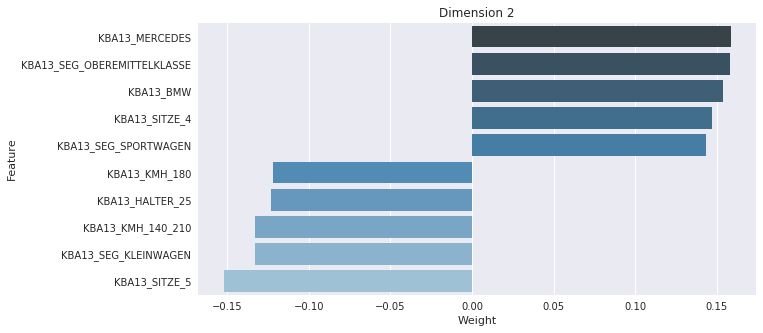

In [20]:
#Component 2
dimension_2_df , explained_variance_df = explained_variance_and_weights_df(azdias_scaled_df, pca, 1)
display(explained_variance_df)
display(dimension_2_df)
print()
plot_pca(dimension_2_df, num = 2)

,Explained_variance
Dimension: 3,0.037


,PRAEGENDE_JUGENDJAHRE,CJT_TYP_1,CJT_TYP_2,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,SEMIO_PFLICHT,FINANZ_ANLEGER,SEMIO_TRADV,ALTERSKATEGORIE_FEIN,ALTER_HH,SEMIO_REL,SEMIO_RAT,RT_KEIN_ANREIZ,RT_UEBERGROESSE,CJT_GESAMTTYP,SEMIO_KULT,ONLINE_AFFINITAET,SEMIO_MAT,UMFELD_ALT,SEMIO_FAM,EINGEZOGENAM_HH_JAHR,ANZ_KINDER,D19_VERSAND_REST,LP_FAMILIE_GROB,LP_FAMILIE_FEIN,D19_TELKO_MOBILE,D19_BANKEN_DIREKT,D19_SCHUHE,NATIONALITAET_KZ,D19_FREIZEIT,GEBURTSJAHR,ANZ_PERSONEN,D19_DROGERIEARTIKEL,D19_TELKO_REST,HEALTH_TYP,D19_KINDERARTIKEL,D19_VERSICHERUNGEN,D19_BANKEN_GROSS,ZABEOTYP,D19_BEKLEIDUNG_REST,KBA05_ALTER2,AKT_DAT_KL,D19_BANKEN_REST,GFK_URLAUBERTYP,D19_HAUS_DEKO,D19_LETZTER_KAUF_BRANCHE_D19_SCHUHE,KBA13_SITZE_6,KBA05_MAXVORB,UNGLEICHENN_FLAG,KBA05_VORB2,OST_WEST_KZ,LP_LEBENSPHASE_GROB,KBA13_HALTER_45,KBA13_SEG_GROSSRAUMVANS,D19_TIERARTIKEL,VK_ZG11,KBA13_ALTERHALTER_45,D19_DIGIT_SERV,KBA05_DIESEL,KBA13_SEG_UTILITIES,MIN_GEBAEUDEJAHR,LP_LEBENSPHASE_FEIN,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,KBA13_HALTER_40,EINGEFUEGT_AM_year,D19_RATGEBER,SEMIO_SOZ,KBA13_SEG_VAN,KBA05_ZUL1,KBA05_CCM3,KBA05_ALTER1,KBA13_GBZ,KBA13_SEG_OBEREMITTELKLASSE,SEMIO_DOM,KBA13_HERST_AUDI_VW,PLZ8_GBZ,CAMEO_INTL_2015_23.0,KBA13_ANTG1,KBA13_HERST_BMW_BENZ,KBA13_VW,KBA13_BJ_2000,KBA13_SEG_GELAENDEWAGEN,D19_BEKLEIDUNG_GEH,KBA05_SEG10,PLZ8_ANTG1,D19_ENERGIE,KBA13_AUTOQUOTE,KBA13_FIAT,D19_BUCH_CD,KBA13_KRSSEG_OBER,KBA13_HALTER_50,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE_D19_BEKLEIDUNG_REST,KBA13_SITZE_4,KBA13_MERCEDES,KBA05_MOTRAD,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_DIREKT,KBA13_CCM_3001,CAMEO_INTL_2015_22.0,CAMEO_DEU_2015_4A,D19_TECHNIK,KBA13_ANZAHL_PKW,KBA13_VORB_3,D19_LETZTER_KAUF_BRANCHE_D19_DROGERIEARTIKEL,KBA05_MOTOR,CAMEO_DEU_2015_3A,D19_BIO_OEKO,KBA13_VORB_2,KBA13_BMW,WOHNLAGE,D19_LETZTER_KAUF_BRANCHE_D19_BUCH_CD,MOBI_RASTER,KBA05_GBZ,KBA13_SEG_WOHNMOBILE,D19_LETZTER_KAUF_BRANCHE_D19_KINDERARTIKEL,KBA13_AUDI,KBA05_HERST2,KBA13_BJ_1999,GEMEINDETYP,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,EINGEFUEGT_AM_month,CAMEO_DEU_2015_9A,CAMEO_INTL_2015_52.0,KBA13_MOTOR,D19_BANKEN_LOKAL,D19_GARTEN,KBA05_ANHANG,KBA13_KMH_140,KBA13_HALTER_55,CAMEO_DEU_2015_3B,CAMEO_INTL_2015_12.0,CAMEO_DEU_2015_2A,KBA05_MOD8,KBA13_CCM_2501,KBA05_VORB1,KBA13_ALTERHALTER_60,KBA05_SEG7,KBA13_CCM_2000,INNENSTADT,KBA13_CCM_2500,KBA05_SEG9,KBA13_KRSSEG_VAN,KBA05_AUTOQUOT,KBA13_SEG_MINIVANS,KBA13_CCM_3000,D19_BILDUNG,KBA13_KW_121,CAMEO_INTL_2015_24.0,KBA13_KRSHERST_AUDI_VW,KBA05_SEG5,KBA05_HERSTTEMP,KBA13_SEG_SPORTWAGEN,ANREDE_KZ,D19_VERSI_ONLINE_QUOTE_12,CAMEO_DEU_2015_5C,CAMEO_INTL_2015_33.0,KBA13_VORB_1_2,KBA05_HERST1,D19_LETZTER_KAUF_BRANCHE_D19_FREIZEIT,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,KBA13_KMH_251,KBA13_SEG_OBERKLASSE,KBA13_KMH_211,KBA13_KMH_250,CAMEO_INTL_2015_41.0,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_GROSS,CAMEO_DEU_2015_4C,KBA13_SEG_MINIWAGEN,KBA05_KRSAQUOT,CAMEO_DEU_2015_9C,KBA05_CCM4,CAMEO_DEU_2015_7A,D19_KOSMETIK,KBA13_HALTER_35,HH_DELTA_FLAG,CAMEO_INTL_2015_32.0,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_4B,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_REST,CAMEO_INTL_2015_51.0,KBA13_HHZ,KONSUMNAEHE,KBA05_SEG8,CAMEO_INTL_2015_31.0,CAMEO_DEU_2015_9B,PLZ8_HHZ,D19_NAHRUNGSERGAENZUNG,CAMEO_DEU_2015_5A,KBA05_MOD1,CAMEO_DEU_2015_3C,KBA05_MAXSEG,GEBAEUDETYP,REGIOTYP,KBA13_KRSAQUOT,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,KBA13_KW_120,KBA13_KMH_0_140,KBA05_KW3,CAMEO_DEU_2015_8B,KBA05_ANTG2,...,D19_LETZTER_KAUF_BRANCHE_D19_BILDUNG,D19_LETZTER_KAUF_BRANCHE_D19_RATGEBER,HH_EINKOMMEN_SCORE,D19_LETZTER_KAUF_BRANCHE_D19_REISEN,KBA05_HERST3,D19_TELKO_ONLINE_QUOTE_12,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_INTL_2015_0.0,KBA13_KRSHERST_FORD_OPEL,SOHO_KZ,CAMEO_DEU_2015_7B,SEMIO_KAEM,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,CAMEO_DEU_2015_6B,KBA13_HERST_FORD_OPEL,KBA05_MOD4,CAMEO_INTL_2015_13.0,KBA13_KW_40,KBA13_KW_90,CAMEO_DEU_2015_8A,D19_LETZTER_KAUF_BRANCHE_D19_HANDWERK,KBA05_SEG4,D19_HANDWERK,CAMEO_DEU_2015_4D,KBA13_KW_61_120,KBA13_CCM_1800,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,KBA13_CCM_1000,GEBAEUDETYP_RASTER,D19_

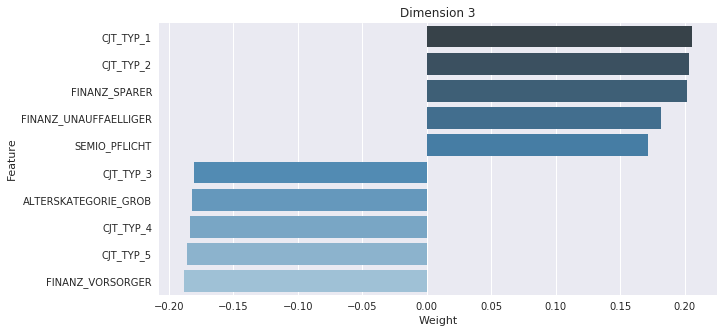

In [21]:
#Component 3
dimension_3_df , explained_variance_df = explained_variance_and_weights_df(azdias_scaled_df, pca, 2)
display(explained_variance_df)
display(dimension_3_df)
print()
plot_pca(dimension_3_df, num = 3)

##  Part 2.4 Clustering

### Part 2.4.1 General Population


Part 2.4.1 General Population
I will first plot the elbow curve so that I will be able to better determine the number of cluster to be used. The method takes a value for k (cluster) and looks at the average distance of each of the data points to the cluster centrers. We can notice that the value decreases as k increases and we choose the number of k where this stops decreasing at a significante rate (the elbow).

I will start of by using the MiniBatchKMeans which is a variant of the KMeans algorithm which uses mini-batches to reduce the computation time. The results of this algotihm is slightly worse than the standard KMeans and because of that, after determining the number of cluster, I will use the regular one.

In [22]:
# Number of cluster to test
import time
start = time.time()
n_clusters = np.arange(2,31)

# run k-means clustering on the data and compute the average distances scores
scores_miniBatch_kmeans = [MiniBatchKMeans(i).fit(azdias_pca).score(azdias_pca) for i in n_clusters]

end = time.time()
print('time [min]:',np.round((end - start)/60, 2))

time [min]: 3.38


In [23]:
scores_miniBatch_kmeans

[-279176519.80395919,
 -276776825.44232684,
 -270238384.24469632,
 -265293136.58332658,
 -262865574.26840341,
 -264684873.0195857,
 -260598393.32022759,
 -256720037.36356166,
 -260013210.31750005,
 -253023920.49166179,
 -251993956.53465766,
 -256969682.13056776,
 -251917101.44757643,
 -255369831.27513525,
 -254928709.7938607,
 -248145256.19737688,
 -248745768.48723349,
 -245873040.52913311,
 -256180680.49695864,
 -244621197.4817614,
 -243672806.3834962,
 -252396918.23284927,
 -252370437.83774275,
 -242974359.14536333,
 -239558745.30287933,
 -241449629.96385202,
 -240222213.02265903,
 -237720512.922427,
 -239188672.07845661]

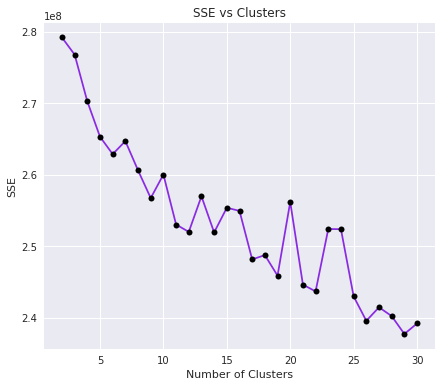

In [24]:
# Elbow Curve
fig= plt.figure(figsize=(7,6))
plt.ylabel('SSE')
plt.xlabel('Number of Clusters')
plt.title('SSE vs Clusters')
plt.plot(n_clusters, 
         np.abs(scores_miniBatch_kmeans), 
         linestyle='-', 
         marker='o',
         markerfacecolor='black',
         markersize=6,
         color='blueviolet');

In [25]:
# 11 clusters
start = time.time()
kmeans = KMeans(n_clusters=11, random_state= 30)

# general population predictions
azdias_predictions = kmeans.fit_predict(azdias_pca)

end = time.time()
print('time [min]:',np.round((end - start)/60, 2))

time [min]: 16.6


In [26]:
# Dump the kmeans file to a pickle object 
pickle.dump(kmeans, open("kmeans.pickle", "wb"))

In [116]:
# Reload pca object 
pca = pickle.load(open("pca.pickle", "rb"))

In [44]:
# Reload kmeans object 
kmeans = pickle.load(open("kmeans.pickle", "rb"))

### Step 2.4.3: Apply All Steps to the Customer Data

In [79]:
# Reload clean_customers object 
#clean_customers = pickle.load(open("clean_customers.pickle", "rb"))

In [85]:
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')
customers.head(8)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [20]:
display('clean_azdias', clean_azdias.shape)
display('clean_customers', clean_customers.shape)

'clean_azdias'

(784541, 427)

'clean_customers'

(140277, 427)

In [117]:
# Scale clean_customers 
scaled_customers = scaler.transform(clean_customers.astype(float))


In [118]:
# Apply pca onto scaled_customers
pca_customers = pca.transform(scaled_customers)

In [119]:
# Apply kmeans 
kmeans_customers = kmeans.predict(pca_customers)

In [120]:
kmeans_customers

array([9, 6, 9, ..., 2, 2, 2], dtype=int32)

In [37]:
centers = kmeans.cluster_centers_
centers.shape

(11, 215)

### Compare Customer data to General Population data

Let's compare the proportion of data in each cluster for the customer and general population data.

In [45]:
general_pop = []
customers = []

# number of clusters
x = [ i + 1 for  i in range(11)]

for i  in range(11):
    general_pop.append((azdias_predictions == i).sum() / len(azdias_predictions))
    customers.append((kmeans_customers == i).sum() /len(kmeans_customers))
    

In [54]:
# Dataframe with clusters

compare_dict = {'Cluster': x,
               'Population': general_pop,
               'Customers':customers}


df_compare = pd.DataFrame(compare_dict)
df_compare.head()

,Cluster,Population,Customers
0,1,0.107056,0.039158
1,2,0.074779,0.039351
2,3,0.123482,0.175631
3,4,0.122797,0.134199
4,5,0.133421,0.007471


In [70]:
# Dump the df_compare file to a pickle object 
pickle.dump(df_compare, open("df_compare.pickle", "wb"))

In [2]:
# Reload kmeans object 
df_compare = pickle.load(open("df_compare.pickle", "rb"))

In [87]:
#Plot chart with clusters
#df_compare.plot( x = 'Cluster',
 #              y = ['Population','Customers'],
 #              kind = 'bar',
               #figsize = (14,8))
#plt.ylabel('Proportion of people in each cluster')
#plt.show()

In [5]:
# Melt dataframe in order to plot in seaborn barplot
melt_df = pd.melt(df_compare, id_vars="Cluster", var_name = 'Dataset', value_name="Proportion")

melt_df.head()

,Cluster,Dataset,Proportion
0,1,Population,0.107056
1,2,Population,0.074779
2,3,Population,0.123482
3,4,Population,0.122797
4,5,Population,0.133421


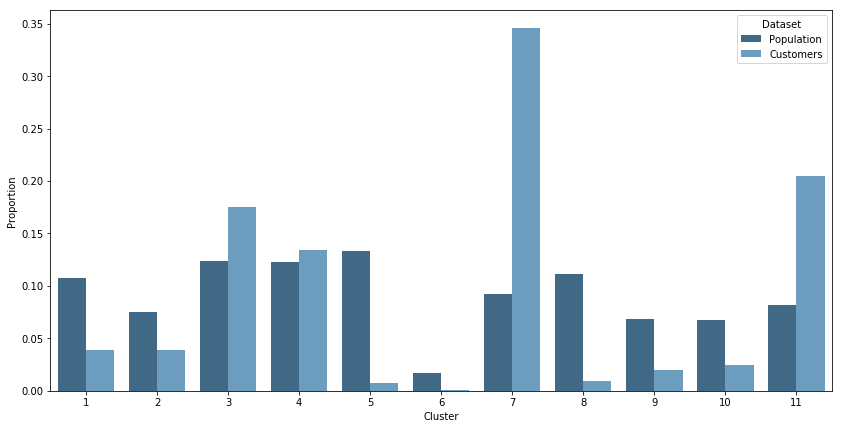

In [6]:
fig = plt.figure( figsize = (14,7))
sns.barplot(x= 'Cluster', y = 'Proportion', hue ='Dataset', data= melt_df, palette= "Blues_d");

In [35]:
#Create dataframe with difference between proportions
df_compare['Difference'] = df_compare.Population - df_compare.Customers
df_diff =  df_compare.loc[:,['Cluster','Difference']]
df_diff

,Cluster,Difference
0,1,0.067898
1,2,0.035428
2,3,-0.052149
3,4,-0.011402
4,5,0.125950
5,6,0.016156
6,7,-0.253653
7,8,0.102556
8,9,0.048950
9,10,0.042953


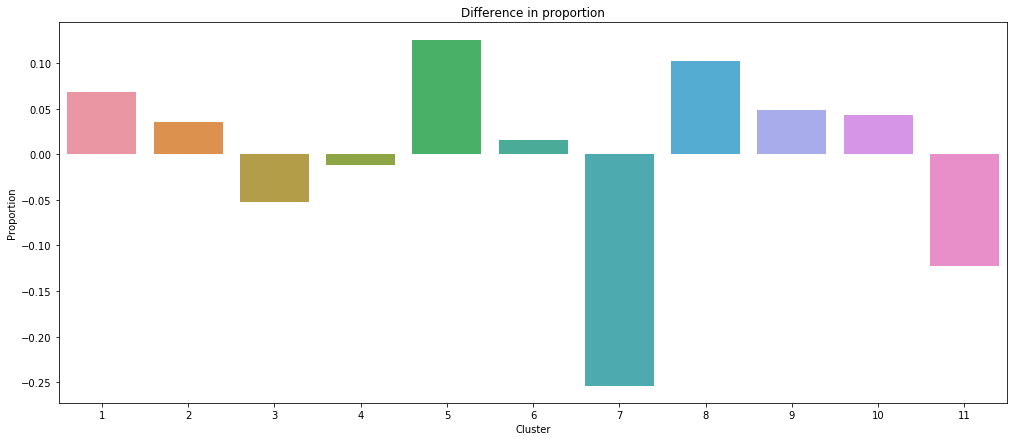

In [42]:
fig = plt.figure(figsize = (17,7))
ax = sns.barplot(x = df_diff['Cluster'],
                y = df_diff['Difference'])
ax.set(title ='Difference in proportion',
      ylabel ='Proportion',
      xlabel = 'Cluster');
                         

In [71]:
# Centers of the most overrepresented and underrepresented clusters (Coordinates of cluster centers)
cluster_7_center_overrep = kmeans.cluster_centers_[7] #overrepresented
cluster_5_center_underrep = kmeans.cluster_centers_[5] #underrepresented

In [51]:
#Transform data back to its original space
center_7_overrep_original_space = pca.inverse_transform(cluster_7_center_overrep)
center_5_underrep_original_space = pca.inverse_transform(cluster_5_center_underrep)

Let's compare the features of both the overrepresented and underrepresented clusters in their original space.


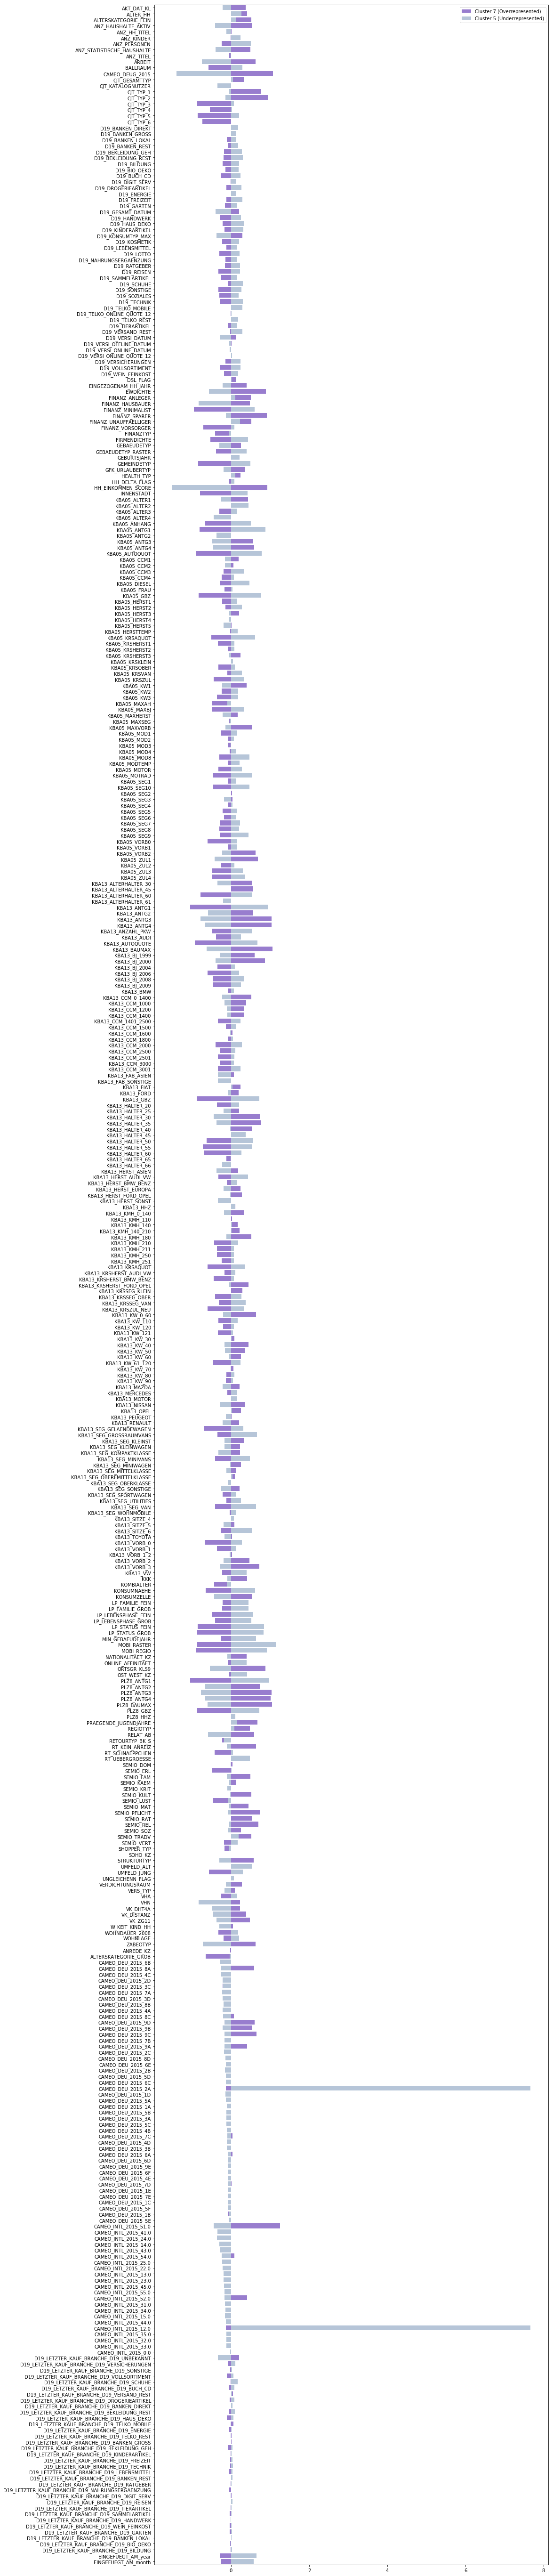

In [70]:
# column names 
feature_names = clean_azdias.columns

plt.figure(figsize =(15,100))

sns.barplot(x=center_7_overrep_original_space,
            y=feature_names, 
            label="Cluster 7 (Overrepresented)",
            color = "mediumpurple")

sns.barplot(x=center_5_underrep_original_space,
            y=feature_names, label="Cluster 5 (Underrepresented)",
            color= "lightsteelblue")

plt.legend();

Now let's understand characteristics of the people that are overrepresented in the customer data compared to the general population.

In [ ]:
from helpers import plot_clusters_distribution_comparison

In [189]:
# Create datafremes with kmeans predictions
df_azdias_clusters_predictions = pd.DataFrame(azdias_predictions, columns = ['Cluster'])
df_customers_clusters_predictions = pd.DataFrame(kmeans_customers, columns = ['Cluster'])

In [190]:
# indices corresponding each cluster ( 5 and 7)
population_pred_index = df_azdias_clusters_predictions[df_azdias_clusters_predictions['Cluster']== 7].index
customers_pred_index = df_customers_clusters_predictions[df_customers_clusters_predictions['Cluster']== 5].index


In [191]:
# Dataframes with rows that correspond to clusters 7 and 5
df_customers_cluster_7 = clean_customers.iloc[customers_pred_index]
df_population_cluster_5 = clean_azdias.iloc[population_pred_index]

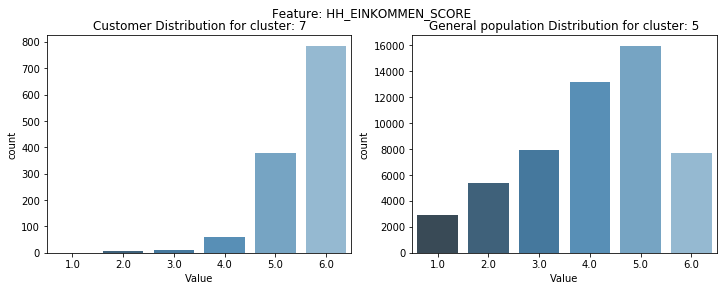

In [182]:
plot_clusters_distribution_comparison(column='HH_EINKOMMEN_SCORE',
                customer=df_customers_cluster_7,
                general=df_population_cluster_5,
               clusters = [7,5])

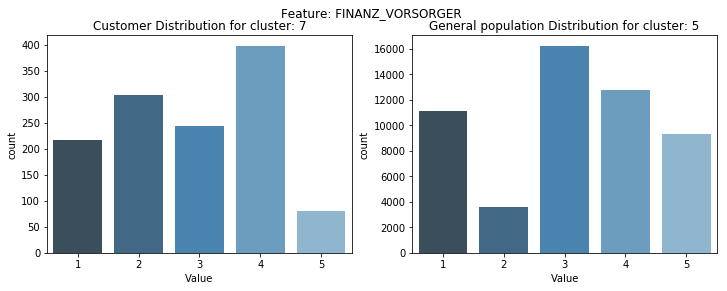

In [194]:
plot_clusters_distribution_comparison(column='FINANZ_VORSORGER',
                customer=df_customers_cluster_7,
                general=df_population_cluster_5,
               clusters = [7,5])

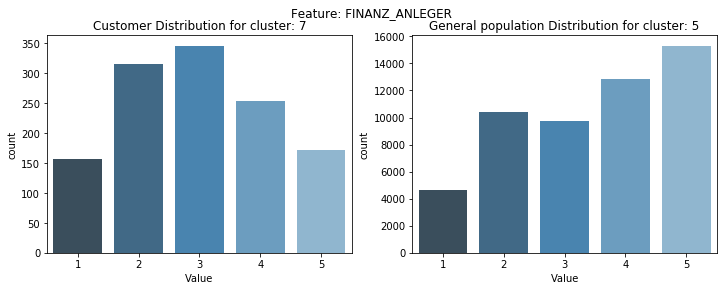

In [195]:
plot_clusters_distribution_comparison(column='FINANZ_ANLEGER',
                customer=df_customers_cluster_7,
                general=df_population_cluster_5,
               clusters = [7,5])

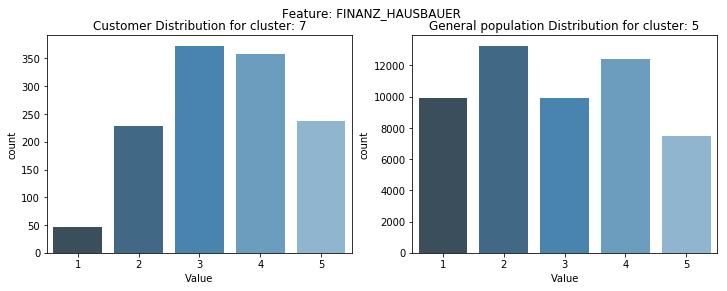

In [197]:
plot_clusters_distribution_comparison(column='FINANZ_HAUSBAUER',
                customer=df_customers_cluster_7,
                general=df_population_cluster_5,
               clusters = [7,5])

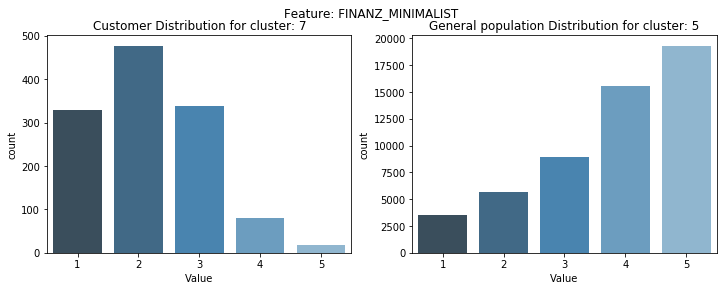

In [198]:
plot_clusters_distribution_comparison(column='FINANZ_MINIMALIST',
                customer=df_customers_cluster_7,
                general=df_population_cluster_5,
               clusters = [7,5])


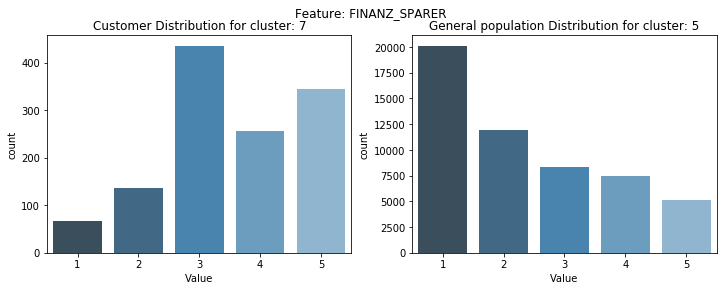

In [199]:
plot_clusters_distribution_comparison(column='FINANZ_SPARER',
                customer=df_customers_cluster_7,
                general=df_population_cluster_5,
               clusters = [7,5])

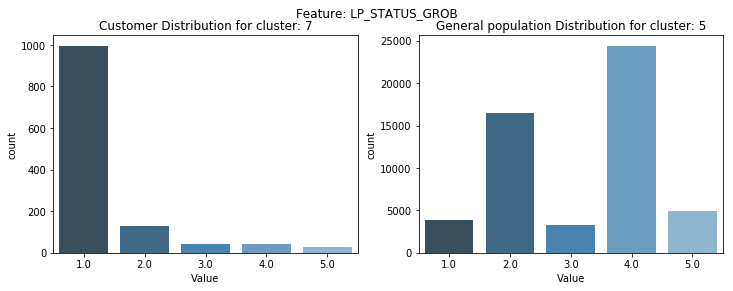

In [200]:
plot_clusters_distribution_comparison(column='LP_STATUS_GROB',
                customer=df_customers_cluster_7,
                general=df_population_cluster_5,
               clusters = [7,5])

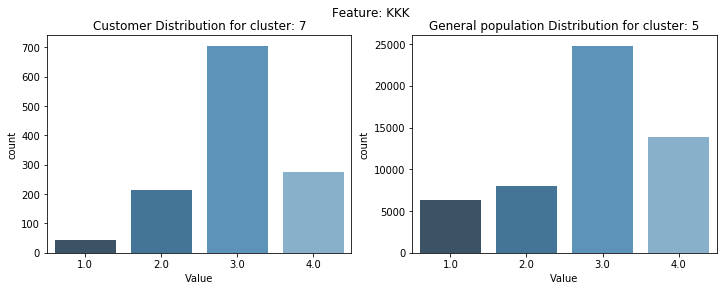

In [201]:
plot_clusters_distribution_comparison(column='KKK',
                customer=df_customers_cluster_7,
                general=df_population_cluster_5,
               clusters = [7,5])

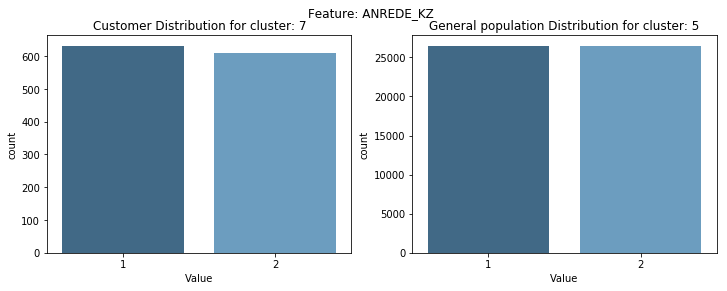

In [202]:
plot_clusters_distribution_comparison(column='ANREDE_KZ',
                customer=df_customers_cluster_7,
                general=df_population_cluster_5,
               clusters = [7,5])

### Conclusion:

The first thint we can notice is that there are cluster that are overreprsented and clusters that are underreprsented by the customers population.

we can also notice that the three clusters with the largest amount of overrepresentation are **cluster 7**, **cluster 11** and **cluster 3**. Because of that, This suggests that those clusters ar more likely to be the target audience for the company.

On the other hand, the three clusters that are most underrepresented are **cluster 1**, **cluster 5**, **cluster 8**






In order to understand a bit more the populations of each cluster we have to check the distribution of each feature. In my case, I've selected features that represents individual finance types of each of them. 

- HH_EINKOMMEN_SCORE: estimated household net income (lower = higher income)
- FINANZ_VORSORGER: individual financial type for those that are prepared
- FINANZ_ANLEGER: individual financial type for Investors)
- LP_LEBENSPHASE_FEIN : life stage
- FINANZ_HAUSBAUER: individual financial type for house owners
- FINANZ_MINIMALIST : those with low financial interest
- FINANZ_SPARER: money-savers
- LP_STATUS_GROB: social status (lower = lower status)
- KKK: purchasing power (lower = higher purchasing power)
- ANREDE_KZ: gender (1 for male and 2 for female)



## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [93]:
#mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [94]:
#mailout_train.head()

In [ ]:
#save_csv(mailout_train, 'data_project', 'Udacity_MAILOUT_052018_TRAIN.csv')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
#mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [ ]:
mailout_test.head()

In [ ]:
#save_csv(mailout_test, 'data_project', 'Udacity_MAILOUT_052018_TEST.csv')

In [ ]:
display(mailout_train.shape )
display(mailout_test.shape)

In [ ]:
mailout_train.CAMEO_INTL_2015.unique()